In [1]:
# Required Libraries
import os
import pandas as pd
import json
import glob
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import time
from sklearn import metrics
from itertools import chain
from collections import Counter
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.preprocessing import LabelBinarizer

### Patient 22

In [2]:
# Reading all JSON files by folder - participant by just changing the number 22
json_files = glob.glob("Emognition_Dataset/Quantum/22/*.json")

emotion_data_22 = []

for file in json_files:
    with open(file) as f:
        try:
            data = json.load(f)
            if isinstance(data, dict) and "frames" in data:
                emotion_names = []
                frames = data["frames"]
                for frame in frames:
                    if "faces" in frame:
                        faces = frame["faces"]
                        for face in faces:
                            emotion_name = face.get("emotionName")
                            if emotion_name:
                                emotion_names.append(emotion_name)
                if emotion_names:
                    file_name = os.path.splitext(os.path.basename(file))[0]
                    emotion_data_22.append([file_name, emotion_names])
        except json.JSONDecodeError:
            print(f"Error parsing JSON file: {file}")
            
# Extracting labels from each video clip

clip_label_22 = {}

clip_label_22['fear'] = np.array(emotion_data_22[0][1])
clip_label_22['enthusiasm'] = np.array(emotion_data_22[1][1])
clip_label_22['surprise'] = np.array(emotion_data_22[2][1])
clip_label_22['neutral'] = np.array(emotion_data_22[3][1])
clip_label_22['awe'] = np.array(emotion_data_22[4][1])
clip_label_22['sadness'] = np.array(emotion_data_22[5][1])
clip_label_22['disgust'] = np.array(emotion_data_22[6][1])
clip_label_22['amusement'] = np.array(emotion_data_22[7][1])
clip_label_22['anger'] = np.array(emotion_data_22[8][1])
clip_label_22['liking'] = np.array(emotion_data_22[9][1])

# Define the mapping dictionary
emotion_mapping = {
    'anger': 0,
    'disgust': 1,
    'sadness': 2,
    'neutral': 3,
    'surprise': 4,
    'happiness': 5
}

clip_label_int_22 = {}
# Map emotion names to numbers
#clip_label_int['baseline'] = np.array([emotion_mapping[emotion] for emotion in clip_label['baseline']]) # Baseline
clip_label_int_22['awe'] = np.array([emotion_mapping[emotion] for emotion in clip_label_22['awe']]) # AWE
clip_label_int_22['fear'] = np.array([emotion_mapping[emotion] for emotion in clip_label_22['fear']]) # Fear
clip_label_int_22['anger'] = np.array([emotion_mapping[emotion] for emotion in clip_label_22['anger']]) # Anger
clip_label_int_22['neutral'] = np.array([emotion_mapping[emotion] for emotion in clip_label_22['neutral']]) # Neutral
clip_label_int_22['liking'] = np.array([emotion_mapping[emotion] for emotion in clip_label_22['liking']]) # Liking
clip_label_int_22['amusement'] = np.array([emotion_mapping[emotion] for emotion in clip_label_22['amusement']]) # Amusement
clip_label_int_22['surprise'] = np.array([emotion_mapping[emotion] for emotion in clip_label_22['surprise']]) # Surprise
clip_label_int_22['enthusiasm'] = np.array([emotion_mapping[emotion] for emotion in clip_label_22['enthusiasm']]) # Enthusiasm
clip_label_int_22['disgust'] = np.array([emotion_mapping[emotion] for emotion in clip_label_22['disgust']]) # Disgust
clip_label_int_22['sadness'] = np.array([emotion_mapping[emotion] for emotion in clip_label_22['sadness']]) # Sadness

# Read the CSV files by folder - participant by just chaniging the number 22

clips_array = ['amusement', 'anger', 'awe', 'disgust', 'enthusiasm', 'fear', 'liking', 'neutral', 'sadness', 'surprise']

dataframes_22 = {}

for clip in clips_array:
    file_path = 'Emognition_Dataset/OpenFace/22/{}.csv'.format(clip)
    dataframes_22[clip] = pd.read_csv(file_path)
    
#####

# Iterate over each clip
for clip in clips_array:
    # Emotion NumPy arrays
    array1 = clip_label_22[clip]
    array2 = clip_label_int_22[clip]

    # Get the number of rows in the DataFrame
    num_rows = len(dataframes_22[clip])

    # Repeat the existing values in the arrays to match the number of rows
    if num_rows > len(array1):
        num_repeats = num_rows - len(array1)
        repeated_values = np.repeat(array1[-1], num_repeats)
        array1 = np.concatenate([array1, repeated_values])

    if num_rows > len(array2):
        num_repeats = num_rows - len(array2)
        repeated_values = np.repeat(array2[-1], num_repeats)
        array2 = np.concatenate([array2, repeated_values])

    # Add arrays as new columns to the DataFrame
    dataframes_22[clip]['class'] = array1
    dataframes_22[clip]['class_int'] = array2
    
#######

anger_df_22 = {}
disgust_df_22 = {}
sadness_df_22 = {}
neutral_df_22 = {}
surprise_df_22 = {}
happiness_df_22 = {}

for clip in clips_array:
    anger_df_22[clip] = dataframes_22[clip][dataframes_22[clip]['class'] == 'anger']
    disgust_df_22[clip] = dataframes_22[clip][dataframes_22[clip]['class'] == 'disgust']
    sadness_df_22[clip] = dataframes_22[clip][dataframes_22[clip]['class'] == 'sadness']
    neutral_df_22[clip] = dataframes_22[clip][dataframes_22[clip]['class'] == 'neutral']
    surprise_df_22[clip] = dataframes_22[clip][dataframes_22[clip]['class'] == 'surprise']
    happiness_df_22[clip] = dataframes_22[clip][dataframes_22[clip]['class'] == 'happiness']

#########

# Create an empty final dataframe
anger_final_df_22 = pd.DataFrame()
disgust_final_df_22 = pd.DataFrame()
sadness_final_df_22 = pd.DataFrame()
neutral_final_df_22 = pd.DataFrame()
surprise_final_df_22 = pd.DataFrame()
happiness_final_df_22 = pd.DataFrame()

# Loop through the dataframes
for clips in clips_array:
    # Append the current dataframe to the final dataframe
    anger_final_df_22 = pd.concat([anger_final_df_22, anger_df_22[clips]], ignore_index=True)
    disgust_final_df_22 = pd.concat([disgust_final_df_22, disgust_df_22[clips]], ignore_index=True)
    sadness_final_df_22 = pd.concat([sadness_final_df_22, sadness_df_22[clips]], ignore_index=True)
    neutral_final_df_22 = pd.concat([neutral_final_df_22, neutral_df_22[clips]], ignore_index=True)
    surprise_final_df_22 = pd.concat([surprise_final_df_22, surprise_df_22[clips]], ignore_index=True)
    happiness_final_df_22 = pd.concat([happiness_final_df_22, happiness_df_22[clips]], ignore_index=True)
    
print(f"In the final dataframe, the number of records for \033[31m anger \033[0m will be: {anger_final_df_22.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m disgust \033[0m will be: {disgust_final_df_22.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m sadness \033[0m will be: {sadness_final_df_22.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m neutral \033[0m will be: {neutral_final_df_22.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m surprise \033[0m will be: {surprise_final_df_22.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m happiness \033[0m will be: {happiness_final_df_22.shape[0]}")

In the final dataframe, the number of records for  anger  will be: 3
In the final dataframe, the number of records for  disgust  will be: 0
In the final dataframe, the number of records for  sadness  will be: 3329
In the final dataframe, the number of records for  neutral  will be: 57809
In the final dataframe, the number of records for  surprise  will be: 154
In the final dataframe, the number of records for  happiness  will be: 2600


### Patient 25

In [3]:
# Reading all JSON files by folder - participant by just changing the number 25
json_files = glob.glob("Emognition_Dataset/Quantum/25/*.json")

emotion_data_25 = []

for file in json_files:
    with open(file) as f:
        try:
            data = json.load(f)
            if isinstance(data, dict) and "frames" in data:
                emotion_names = []
                frames = data["frames"]
                for frame in frames:
                    if "faces" in frame:
                        faces = frame["faces"]
                        for face in faces:
                            emotion_name = face.get("emotionName")
                            if emotion_name:
                                emotion_names.append(emotion_name)
                if emotion_names:
                    file_name = os.path.splitext(os.path.basename(file))[0]
                    emotion_data_25.append([file_name, emotion_names])
        except json.JSONDecodeError:
            print(f"Error parsing JSON file: {file}")
            
# Extracting labels from each video clip

clip_label_25 = {}

clip_label_25['fear'] = np.array(emotion_data_25[0][1])
clip_label_25['enthusiasm'] = np.array(emotion_data_25[1][1])
clip_label_25['surprise'] = np.array(emotion_data_25[2][1])
clip_label_25['neutral'] = np.array(emotion_data_25[3][1])
clip_label_25['awe'] = np.array(emotion_data_25[4][1])
clip_label_25['sadness'] = np.array(emotion_data_25[5][1])
clip_label_25['disgust'] = np.array(emotion_data_25[6][1])
clip_label_25['amusement'] = np.array(emotion_data_25[7][1])
clip_label_25['anger'] = np.array(emotion_data_25[8][1])
clip_label_25['liking'] = np.array(emotion_data_25[9][1])

# Define the mapping dictionary
emotion_mapping = {
    'anger': 0,
    'disgust': 1,
    'sadness': 2,
    'neutral': 3,
    'surprise': 4,
    'happiness': 5
}

clip_label_int_25 = {}
# Map emotion names to numbers
#clip_label_int['baseline'] = np.array([emotion_mapping[emotion] for emotion in clip_label['baseline']]) # Baseline
clip_label_int_25['awe'] = np.array([emotion_mapping[emotion] for emotion in clip_label_25['awe']]) # AWE
clip_label_int_25['fear'] = np.array([emotion_mapping[emotion] for emotion in clip_label_25['fear']]) # Fear
clip_label_int_25['anger'] = np.array([emotion_mapping[emotion] for emotion in clip_label_25['anger']]) # Anger
clip_label_int_25['neutral'] = np.array([emotion_mapping[emotion] for emotion in clip_label_25['neutral']]) # Neutral
clip_label_int_25['liking'] = np.array([emotion_mapping[emotion] for emotion in clip_label_25['liking']]) # Liking
clip_label_int_25['amusement'] = np.array([emotion_mapping[emotion] for emotion in clip_label_25['amusement']]) # Amusement
clip_label_int_25['surprise'] = np.array([emotion_mapping[emotion] for emotion in clip_label_25['surprise']]) # Surprise
clip_label_int_25['enthusiasm'] = np.array([emotion_mapping[emotion] for emotion in clip_label_25['enthusiasm']]) # Enthusiasm
clip_label_int_25['disgust'] = np.array([emotion_mapping[emotion] for emotion in clip_label_25['disgust']]) # Disgust
clip_label_int_25['sadness'] = np.array([emotion_mapping[emotion] for emotion in clip_label_25['sadness']]) # Sadness

# Read the CSV files by folder - participant by just chaniging the number 25

clips_array = ['amusement', 'anger', 'awe', 'disgust', 'enthusiasm', 'fear', 'liking', 'neutral', 'sadness', 'surprise']

dataframes_25 = {}

for clip in clips_array:
    file_path = 'Emognition_Dataset/OpenFace/25/{}.csv'.format(clip)
    dataframes_25[clip] = pd.read_csv(file_path)
    
#####

# Iterate over each clip
for clip in clips_array:
    # Emotion NumPy arrays
    array1 = clip_label_25[clip]
    array2 = clip_label_int_25[clip]

    # Get the number of rows in the DataFrame
    num_rows = len(dataframes_25[clip])

    # Repeat the existing values in the arrays to match the number of rows
    if num_rows > len(array1):
        num_repeats = num_rows - len(array1)
        repeated_values = np.repeat(array1[-1], num_repeats)
        array1 = np.concatenate([array1, repeated_values])

    if num_rows > len(array2):
        num_repeats = num_rows - len(array2)
        repeated_values = np.repeat(array2[-1], num_repeats)
        array2 = np.concatenate([array2, repeated_values])

    # Add arrays as new columns to the DataFrame
    dataframes_25[clip]['class'] = array1
    dataframes_25[clip]['class_int'] = array2
    
#######

anger_df_25 = {}
disgust_df_25 = {}
sadness_df_25 = {}
neutral_df_25 = {}
surprise_df_25 = {}
happiness_df_25 = {}

for clip in clips_array:
    anger_df_25[clip] = dataframes_25[clip][dataframes_25[clip]['class'] == 'anger']
    disgust_df_25[clip] = dataframes_25[clip][dataframes_25[clip]['class'] == 'disgust']
    sadness_df_25[clip] = dataframes_25[clip][dataframes_25[clip]['class'] == 'sadness']
    neutral_df_25[clip] = dataframes_25[clip][dataframes_25[clip]['class'] == 'neutral']
    surprise_df_25[clip] = dataframes_25[clip][dataframes_25[clip]['class'] == 'surprise']
    happiness_df_25[clip] = dataframes_25[clip][dataframes_25[clip]['class'] == 'happiness']

#########

# Create an empty final dataframe
anger_final_df_25 = pd.DataFrame()
disgust_final_df_25 = pd.DataFrame()
sadness_final_df_25 = pd.DataFrame()
neutral_final_df_25 = pd.DataFrame()
surprise_final_df_25 = pd.DataFrame()
happiness_final_df_25 = pd.DataFrame()

# Loop through the dataframes
for clips in clips_array:
    # Append the current dataframe to the final dataframe
    anger_final_df_25 = pd.concat([anger_final_df_25, anger_df_25[clips]], ignore_index=True)
    disgust_final_df_25 = pd.concat([disgust_final_df_25, disgust_df_25[clips]], ignore_index=True)
    sadness_final_df_25 = pd.concat([sadness_final_df_25, sadness_df_25[clips]], ignore_index=True)
    neutral_final_df_25 = pd.concat([neutral_final_df_25, neutral_df_25[clips]], ignore_index=True)
    surprise_final_df_25 = pd.concat([surprise_final_df_25, surprise_df_25[clips]], ignore_index=True)
    happiness_final_df_25 = pd.concat([happiness_final_df_25, happiness_df_25[clips]], ignore_index=True)
    
print(f"In the final dataframe, the number of records for \033[31m anger \033[0m will be: {anger_final_df_25.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m disgust \033[0m will be: {disgust_final_df_25.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m sadness \033[0m will be: {sadness_final_df_25.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m neutral \033[0m will be: {neutral_final_df_25.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m surprise \033[0m will be: {surprise_final_df_25.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m happiness \033[0m will be: {happiness_final_df_25.shape[0]}")

In the final dataframe, the number of records for  anger  will be: 140
In the final dataframe, the number of records for  disgust  will be: 0
In the final dataframe, the number of records for  sadness  will be: 2837
In the final dataframe, the number of records for  neutral  will be: 60549
In the final dataframe, the number of records for  surprise  will be: 348
In the final dataframe, the number of records for  happiness  will be: 126


### Patient 28

In [4]:
# Reading all JSON files by folder - participant by just changing the number 28
json_files = glob.glob("Emognition_Dataset/Quantum/28/*.json")

emotion_data_28 = []

for file in json_files:
    with open(file) as f:
        try:
            data = json.load(f)
            if isinstance(data, dict) and "frames" in data:
                emotion_names = []
                frames = data["frames"]
                for frame in frames:
                    if "faces" in frame:
                        faces = frame["faces"]
                        for face in faces:
                            emotion_name = face.get("emotionName")
                            if emotion_name:
                                emotion_names.append(emotion_name)
                if emotion_names:
                    file_name = os.path.splitext(os.path.basename(file))[0]
                    emotion_data_28.append([file_name, emotion_names])
        except json.JSONDecodeError:
            print(f"Error parsing JSON file: {file}")
            
# Extracting labels from each video clip

clip_label_28 = {}

clip_label_28['fear'] = np.array(emotion_data_28[0][1])
clip_label_28['enthusiasm'] = np.array(emotion_data_28[1][1])
clip_label_28['surprise'] = np.array(emotion_data_28[2][1])
clip_label_28['neutral'] = np.array(emotion_data_28[3][1])
clip_label_28['awe'] = np.array(emotion_data_28[4][1])
clip_label_28['sadness'] = np.array(emotion_data_28[5][1])
clip_label_28['disgust'] = np.array(emotion_data_28[6][1])
clip_label_28['amusement'] = np.array(emotion_data_28[7][1])
clip_label_28['anger'] = np.array(emotion_data_28[8][1])
clip_label_28['liking'] = np.array(emotion_data_28[9][1])

# Define the mapping dictionary
emotion_mapping = {
    'anger': 0,
    'disgust': 1,
    'sadness': 2,
    'neutral': 3,
    'surprise': 4,
    'happiness': 5
}

clip_label_int_28 = {}
# Map emotion names to numbers
#clip_label_int['baseline'] = np.array([emotion_mapping[emotion] for emotion in clip_label['baseline']]) # Baseline
clip_label_int_28['awe'] = np.array([emotion_mapping[emotion] for emotion in clip_label_28['awe']]) # AWE
clip_label_int_28['fear'] = np.array([emotion_mapping[emotion] for emotion in clip_label_28['fear']]) # Fear
clip_label_int_28['anger'] = np.array([emotion_mapping[emotion] for emotion in clip_label_28['anger']]) # Anger
clip_label_int_28['neutral'] = np.array([emotion_mapping[emotion] for emotion in clip_label_28['neutral']]) # Neutral
clip_label_int_28['liking'] = np.array([emotion_mapping[emotion] for emotion in clip_label_28['liking']]) # Liking
clip_label_int_28['amusement'] = np.array([emotion_mapping[emotion] for emotion in clip_label_28['amusement']]) # Amusement
clip_label_int_28['surprise'] = np.array([emotion_mapping[emotion] for emotion in clip_label_28['surprise']]) # Surprise
clip_label_int_28['enthusiasm'] = np.array([emotion_mapping[emotion] for emotion in clip_label_28['enthusiasm']]) # Enthusiasm
clip_label_int_28['disgust'] = np.array([emotion_mapping[emotion] for emotion in clip_label_28['disgust']]) # Disgust
clip_label_int_28['sadness'] = np.array([emotion_mapping[emotion] for emotion in clip_label_28['sadness']]) # Sadness

# Read the CSV files by folder - participant by just chaniging the number 28

clips_array = ['amusement', 'anger', 'awe', 'disgust', 'enthusiasm', 'fear', 'liking', 'neutral', 'sadness', 'surprise']

dataframes_28 = {}

for clip in clips_array:
    file_path = 'Emognition_Dataset/OpenFace/28/{}.csv'.format(clip)
    dataframes_28[clip] = pd.read_csv(file_path)
    
#####

# Iterate over each clip
for clip in clips_array:
    # Emotion NumPy arrays
    array1 = clip_label_28[clip]
    array2 = clip_label_int_28[clip]

    # Get the number of rows in the DataFrame
    num_rows = len(dataframes_28[clip])

    # Repeat the existing values in the arrays to match the number of rows
    if num_rows > len(array1):
        num_repeats = num_rows - len(array1)
        repeated_values = np.repeat(array1[-1], num_repeats)
        array1 = np.concatenate([array1, repeated_values])

    if num_rows > len(array2):
        num_repeats = num_rows - len(array2)
        repeated_values = np.repeat(array2[-1], num_repeats)
        array2 = np.concatenate([array2, repeated_values])

    # Add arrays as new columns to the DataFrame
    dataframes_28[clip]['class'] = array1
    dataframes_28[clip]['class_int'] = array2
    
#######

anger_df_28 = {}
disgust_df_28 = {}
sadness_df_28 = {}
neutral_df_28 = {}
surprise_df_28 = {}
happiness_df_28 = {}

for clip in clips_array:
    anger_df_28[clip] = dataframes_28[clip][dataframes_28[clip]['class'] == 'anger']
    disgust_df_28[clip] = dataframes_28[clip][dataframes_28[clip]['class'] == 'disgust']
    sadness_df_28[clip] = dataframes_28[clip][dataframes_28[clip]['class'] == 'sadness']
    neutral_df_28[clip] = dataframes_28[clip][dataframes_28[clip]['class'] == 'neutral']
    surprise_df_28[clip] = dataframes_28[clip][dataframes_28[clip]['class'] == 'surprise']
    happiness_df_28[clip] = dataframes_28[clip][dataframes_28[clip]['class'] == 'happiness']

#########

# Create an empty final dataframe
anger_final_df_28 = pd.DataFrame()
disgust_final_df_28 = pd.DataFrame()
sadness_final_df_28 = pd.DataFrame()
neutral_final_df_28 = pd.DataFrame()
surprise_final_df_28 = pd.DataFrame()
happiness_final_df_28 = pd.DataFrame()

# Loop through the dataframes
for clips in clips_array:
    # Append the current dataframe to the final dataframe
    anger_final_df_28 = pd.concat([anger_final_df_28, anger_df_28[clips]], ignore_index=True)
    disgust_final_df_28 = pd.concat([disgust_final_df_28, disgust_df_28[clips]], ignore_index=True)
    sadness_final_df_28 = pd.concat([sadness_final_df_28, sadness_df_28[clips]], ignore_index=True)
    neutral_final_df_28 = pd.concat([neutral_final_df_28, neutral_df_28[clips]], ignore_index=True)
    surprise_final_df_28 = pd.concat([surprise_final_df_28, surprise_df_28[clips]], ignore_index=True)
    happiness_final_df_28 = pd.concat([happiness_final_df_28, happiness_df_28[clips]], ignore_index=True)
    
print(f"In the final dataframe, the number of records for \033[31m anger \033[0m will be: {anger_final_df_28.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m disgust \033[0m will be: {disgust_final_df_28.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m sadness \033[0m will be: {sadness_final_df_28.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m neutral \033[0m will be: {neutral_final_df_28.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m surprise \033[0m will be: {surprise_final_df_28.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m happiness \033[0m will be: {happiness_final_df_28.shape[0]}")

In the final dataframe, the number of records for  anger  will be: 17
In the final dataframe, the number of records for  disgust  will be: 58
In the final dataframe, the number of records for  sadness  will be: 2327
In the final dataframe, the number of records for  neutral  will be: 61107
In the final dataframe, the number of records for  surprise  will be: 410
In the final dataframe, the number of records for  happiness  will be: 203


### Patient 29

In [5]:
# Reading all JSON files by folder - participant by just changing the number 29
json_files = glob.glob("Emognition_Dataset/Quantum/29/*.json")

emotion_data_29 = []

for file in json_files:
    with open(file) as f:
        try:
            data = json.load(f)
            if isinstance(data, dict) and "frames" in data:
                emotion_names = []
                frames = data["frames"]
                for frame in frames:
                    if "faces" in frame:
                        faces = frame["faces"]
                        for face in faces:
                            emotion_name = face.get("emotionName")
                            if emotion_name:
                                emotion_names.append(emotion_name)
                if emotion_names:
                    file_name = os.path.splitext(os.path.basename(file))[0]
                    emotion_data_29.append([file_name, emotion_names])
        except json.JSONDecodeError:
            print(f"Error parsing JSON file: {file}")
            
# Extracting labels from each video clip

clip_label_29 = {}

clip_label_29['fear'] = np.array(emotion_data_29[0][1])
clip_label_29['enthusiasm'] = np.array(emotion_data_29[1][1])
clip_label_29['surprise'] = np.array(emotion_data_29[2][1])
clip_label_29['neutral'] = np.array(emotion_data_29[3][1])
clip_label_29['awe'] = np.array(emotion_data_29[4][1])
clip_label_29['sadness'] = np.array(emotion_data_29[5][1])
clip_label_29['disgust'] = np.array(emotion_data_29[6][1])
clip_label_29['amusement'] = np.array(emotion_data_29[7][1])
clip_label_29['anger'] = np.array(emotion_data_29[8][1])
clip_label_29['liking'] = np.array(emotion_data_29[9][1])

# Define the mapping dictionary
emotion_mapping = {
    'anger': 0,
    'disgust': 1,
    'sadness': 2,
    'neutral': 3,
    'surprise': 4,
    'happiness': 5
}

clip_label_int_29 = {}
# Map emotion names to numbers
#clip_label_int['baseline'] = np.array([emotion_mapping[emotion] for emotion in clip_label['baseline']]) # Baseline
clip_label_int_29['awe'] = np.array([emotion_mapping[emotion] for emotion in clip_label_29['awe']]) # AWE
clip_label_int_29['fear'] = np.array([emotion_mapping[emotion] for emotion in clip_label_29['fear']]) # Fear
clip_label_int_29['anger'] = np.array([emotion_mapping[emotion] for emotion in clip_label_29['anger']]) # Anger
clip_label_int_29['neutral'] = np.array([emotion_mapping[emotion] for emotion in clip_label_29['neutral']]) # Neutral
clip_label_int_29['liking'] = np.array([emotion_mapping[emotion] for emotion in clip_label_29['liking']]) # Liking
clip_label_int_29['amusement'] = np.array([emotion_mapping[emotion] for emotion in clip_label_29['amusement']]) # Amusement
clip_label_int_29['surprise'] = np.array([emotion_mapping[emotion] for emotion in clip_label_29['surprise']]) # Surprise
clip_label_int_29['enthusiasm'] = np.array([emotion_mapping[emotion] for emotion in clip_label_29['enthusiasm']]) # Enthusiasm
clip_label_int_29['disgust'] = np.array([emotion_mapping[emotion] for emotion in clip_label_29['disgust']]) # Disgust
clip_label_int_29['sadness'] = np.array([emotion_mapping[emotion] for emotion in clip_label_29['sadness']]) # Sadness

# Read the CSV files by folder - participant by just chaniging the number 29

clips_array = ['amusement', 'anger', 'awe', 'disgust', 'enthusiasm', 'fear', 'liking', 'neutral', 'sadness', 'surprise']

dataframes_29 = {}

for clip in clips_array:
    file_path = 'Emognition_Dataset/OpenFace/29/{}.csv'.format(clip)
    dataframes_29[clip] = pd.read_csv(file_path)
    
#####

# Iterate over each clip
for clip in clips_array:
    # Emotion NumPy arrays
    array1 = clip_label_29[clip]
    array2 = clip_label_int_29[clip]

    # Get the number of rows in the DataFrame
    num_rows = len(dataframes_29[clip])

    # Repeat the existing values in the arrays to match the number of rows
    if num_rows > len(array1):
        num_repeats = num_rows - len(array1)
        repeated_values = np.repeat(array1[-1], num_repeats)
        array1 = np.concatenate([array1, repeated_values])

    if num_rows > len(array2):
        num_repeats = num_rows - len(array2)
        repeated_values = np.repeat(array2[-1], num_repeats)
        array2 = np.concatenate([array2, repeated_values])

    # Add arrays as new columns to the DataFrame
    dataframes_29[clip]['class'] = array1
    dataframes_29[clip]['class_int'] = array2
    
#######

anger_df_29 = {}
disgust_df_29 = {}
sadness_df_29 = {}
neutral_df_29 = {}
surprise_df_29 = {}
happiness_df_29 = {}

for clip in clips_array:
    anger_df_29[clip] = dataframes_29[clip][dataframes_29[clip]['class'] == 'anger']
    disgust_df_29[clip] = dataframes_29[clip][dataframes_29[clip]['class'] == 'disgust']
    sadness_df_29[clip] = dataframes_29[clip][dataframes_29[clip]['class'] == 'sadness']
    neutral_df_29[clip] = dataframes_29[clip][dataframes_29[clip]['class'] == 'neutral']
    surprise_df_29[clip] = dataframes_29[clip][dataframes_29[clip]['class'] == 'surprise']
    happiness_df_29[clip] = dataframes_29[clip][dataframes_29[clip]['class'] == 'happiness']

#########

# Create an empty final dataframe
anger_final_df_29 = pd.DataFrame()
disgust_final_df_29 = pd.DataFrame()
sadness_final_df_29 = pd.DataFrame()
neutral_final_df_29 = pd.DataFrame()
surprise_final_df_29 = pd.DataFrame()
happiness_final_df_29 = pd.DataFrame()

# Loop through the dataframes
for clips in clips_array:
    # Append the current dataframe to the final dataframe
    anger_final_df_29 = pd.concat([anger_final_df_29, anger_df_29[clips]], ignore_index=True)
    disgust_final_df_29 = pd.concat([disgust_final_df_29, disgust_df_29[clips]], ignore_index=True)
    sadness_final_df_29 = pd.concat([sadness_final_df_29, sadness_df_29[clips]], ignore_index=True)
    neutral_final_df_29 = pd.concat([neutral_final_df_29, neutral_df_29[clips]], ignore_index=True)
    surprise_final_df_29 = pd.concat([surprise_final_df_29, surprise_df_29[clips]], ignore_index=True)
    happiness_final_df_29 = pd.concat([happiness_final_df_29, happiness_df_29[clips]], ignore_index=True)
    
print(f"In the final dataframe, the number of records for \033[31m anger \033[0m will be: {anger_final_df_29.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m disgust \033[0m will be: {disgust_final_df_29.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m sadness \033[0m will be: {sadness_final_df_29.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m neutral \033[0m will be: {neutral_final_df_29.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m surprise \033[0m will be: {surprise_final_df_29.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m happiness \033[0m will be: {happiness_final_df_29.shape[0]}")

In the final dataframe, the number of records for  anger  will be: 3
In the final dataframe, the number of records for  disgust  will be: 14010
In the final dataframe, the number of records for  sadness  will be: 0
In the final dataframe, the number of records for  neutral  will be: 38354
In the final dataframe, the number of records for  surprise  will be: 9
In the final dataframe, the number of records for  happiness  will be: 11656


### Patient 32

In [6]:
# Reading all JSON files by folder - participant by just changing the number 32
json_files = glob.glob("Emognition_Dataset/Quantum/32/*.json")

emotion_data_32 = []

for file in json_files:
    with open(file) as f:
        try:
            data = json.load(f)
            if isinstance(data, dict) and "frames" in data:
                emotion_names = []
                frames = data["frames"]
                for frame in frames:
                    if "faces" in frame:
                        faces = frame["faces"]
                        for face in faces:
                            emotion_name = face.get("emotionName")
                            if emotion_name:
                                emotion_names.append(emotion_name)
                if emotion_names:
                    file_name = os.path.splitext(os.path.basename(file))[0]
                    emotion_data_32.append([file_name, emotion_names])
        except json.JSONDecodeError:
            print(f"Error parsing JSON file: {file}")
            
# Extracting labels from each video clip

clip_label_32 = {}

clip_label_32['fear'] = np.array(emotion_data_32[0][1])
clip_label_32['enthusiasm'] = np.array(emotion_data_32[1][1])
clip_label_32['surprise'] = np.array(emotion_data_32[2][1])
clip_label_32['neutral'] = np.array(emotion_data_32[3][1])
clip_label_32['awe'] = np.array(emotion_data_32[4][1])
clip_label_32['sadness'] = np.array(emotion_data_32[5][1])
clip_label_32['disgust'] = np.array(emotion_data_32[6][1])
clip_label_32['amusement'] = np.array(emotion_data_32[7][1])
clip_label_32['anger'] = np.array(emotion_data_32[8][1])
clip_label_32['liking'] = np.array(emotion_data_32[9][1])

# Define the mapping dictionary
emotion_mapping = {
    'anger': 0,
    'disgust': 1,
    'sadness': 2,
    'neutral': 3,
    'surprise': 4,
    'happiness': 5
}

clip_label_int_32 = {}
# Map emotion names to numbers
#clip_label_int['baseline'] = np.array([emotion_mapping[emotion] for emotion in clip_label['baseline']]) # Baseline
clip_label_int_32['awe'] = np.array([emotion_mapping[emotion] for emotion in clip_label_32['awe']]) # AWE
clip_label_int_32['fear'] = np.array([emotion_mapping[emotion] for emotion in clip_label_32['fear']]) # Fear
clip_label_int_32['anger'] = np.array([emotion_mapping[emotion] for emotion in clip_label_32['anger']]) # Anger
clip_label_int_32['neutral'] = np.array([emotion_mapping[emotion] for emotion in clip_label_32['neutral']]) # Neutral
clip_label_int_32['liking'] = np.array([emotion_mapping[emotion] for emotion in clip_label_32['liking']]) # Liking
clip_label_int_32['amusement'] = np.array([emotion_mapping[emotion] for emotion in clip_label_32['amusement']]) # Amusement
clip_label_int_32['surprise'] = np.array([emotion_mapping[emotion] for emotion in clip_label_32['surprise']]) # Surprise
clip_label_int_32['enthusiasm'] = np.array([emotion_mapping[emotion] for emotion in clip_label_32['enthusiasm']]) # Enthusiasm
clip_label_int_32['disgust'] = np.array([emotion_mapping[emotion] for emotion in clip_label_32['disgust']]) # Disgust
clip_label_int_32['sadness'] = np.array([emotion_mapping[emotion] for emotion in clip_label_32['sadness']]) # Sadness

# Read the CSV files by folder - participant by just chaniging the number 32

clips_array = ['amusement', 'anger', 'awe', 'disgust', 'enthusiasm', 'fear', 'liking', 'neutral', 'sadness', 'surprise']

dataframes_32 = {}

for clip in clips_array:
    file_path = 'Emognition_Dataset/OpenFace/32/{}.csv'.format(clip)
    dataframes_32[clip] = pd.read_csv(file_path)
    
#####

# Iterate over each clip
for clip in clips_array:
    # Emotion NumPy arrays
    array1 = clip_label_32[clip]
    array2 = clip_label_int_32[clip]

    # Get the number of rows in the DataFrame
    num_rows = len(dataframes_32[clip])

    # Repeat the existing values in the arrays to match the number of rows
    if num_rows > len(array1):
        num_repeats = num_rows - len(array1)
        repeated_values = np.repeat(array1[-1], num_repeats)
        array1 = np.concatenate([array1, repeated_values])

    if num_rows > len(array2):
        num_repeats = num_rows - len(array2)
        repeated_values = np.repeat(array2[-1], num_repeats)
        array2 = np.concatenate([array2, repeated_values])

    # Add arrays as new columns to the DataFrame
    dataframes_32[clip]['class'] = array1
    dataframes_32[clip]['class_int'] = array2
    
#######

anger_df_32 = {}
disgust_df_32 = {}
sadness_df_32 = {}
neutral_df_32 = {}
surprise_df_32 = {}
happiness_df_32 = {}

for clip in clips_array:
    anger_df_32[clip] = dataframes_32[clip][dataframes_32[clip]['class'] == 'anger']
    disgust_df_32[clip] = dataframes_32[clip][dataframes_32[clip]['class'] == 'disgust']
    sadness_df_32[clip] = dataframes_32[clip][dataframes_32[clip]['class'] == 'sadness']
    neutral_df_32[clip] = dataframes_32[clip][dataframes_32[clip]['class'] == 'neutral']
    surprise_df_32[clip] = dataframes_32[clip][dataframes_32[clip]['class'] == 'surprise']
    happiness_df_32[clip] = dataframes_32[clip][dataframes_32[clip]['class'] == 'happiness']

#########

# Create an empty final dataframe
anger_final_df_32 = pd.DataFrame()
disgust_final_df_32 = pd.DataFrame()
sadness_final_df_32 = pd.DataFrame()
neutral_final_df_32 = pd.DataFrame()
surprise_final_df_32 = pd.DataFrame()
happiness_final_df_32 = pd.DataFrame()

# Loop through the dataframes
for clips in clips_array:
    # Append the current dataframe to the final dataframe
    anger_final_df_32 = pd.concat([anger_final_df_32, anger_df_32[clips]], ignore_index=True)
    disgust_final_df_32 = pd.concat([disgust_final_df_32, disgust_df_32[clips]], ignore_index=True)
    sadness_final_df_32 = pd.concat([sadness_final_df_32, sadness_df_32[clips]], ignore_index=True)
    neutral_final_df_32 = pd.concat([neutral_final_df_32, neutral_df_32[clips]], ignore_index=True)
    surprise_final_df_32 = pd.concat([surprise_final_df_32, surprise_df_32[clips]], ignore_index=True)
    happiness_final_df_32 = pd.concat([happiness_final_df_32, happiness_df_32[clips]], ignore_index=True)
    
print(f"In the final dataframe, the number of records for \033[32m anger \033[0m will be: {anger_final_df_32.shape[0]}")
print(f"In the final dataframe, the number of records for \033[32m disgust \033[0m will be: {disgust_final_df_32.shape[0]}")
print(f"In the final dataframe, the number of records for \033[32m sadness \033[0m will be: {sadness_final_df_32.shape[0]}")
print(f"In the final dataframe, the number of records for \033[32m neutral \033[0m will be: {neutral_final_df_32.shape[0]}")
print(f"In the final dataframe, the number of records for \033[32m surprise \033[0m will be: {surprise_final_df_32.shape[0]}")
print(f"In the final dataframe, the number of records for \033[32m happiness \033[0m will be: {happiness_final_df_32.shape[0]}")

In the final dataframe, the number of records for  anger  will be: 470
In the final dataframe, the number of records for  disgust  will be: 1
In the final dataframe, the number of records for  sadness  will be: 181
In the final dataframe, the number of records for  neutral  will be: 59786
In the final dataframe, the number of records for  surprise  will be: 0
In the final dataframe, the number of records for  happiness  will be: 3577


### Patient 39

In [7]:
# Reading all JSON files by folder - participant by just changing the number 39
json_files = glob.glob("Emognition_Dataset/Quantum/39/*.json")

emotion_data_39 = []

for file in json_files:
    with open(file) as f:
        try:
            data = json.load(f)
            if isinstance(data, dict) and "frames" in data:
                emotion_names = []
                frames = data["frames"]
                for frame in frames:
                    if "faces" in frame:
                        faces = frame["faces"]
                        for face in faces:
                            emotion_name = face.get("emotionName")
                            if emotion_name:
                                emotion_names.append(emotion_name)
                if emotion_names:
                    file_name = os.path.splitext(os.path.basename(file))[0]
                    emotion_data_39.append([file_name, emotion_names])
        except json.JSONDecodeError:
            print(f"Error parsing JSON file: {file}")
            
# Extracting labels from each video clip

clip_label_39 = {}

clip_label_39['fear'] = np.array(emotion_data_39[0][1])
clip_label_39['enthusiasm'] = np.array(emotion_data_39[1][1])
clip_label_39['surprise'] = np.array(emotion_data_39[2][1])
clip_label_39['neutral'] = np.array(emotion_data_39[3][1])
clip_label_39['awe'] = np.array(emotion_data_39[4][1])
clip_label_39['sadness'] = np.array(emotion_data_39[5][1])
clip_label_39['disgust'] = np.array(emotion_data_39[6][1])
clip_label_39['amusement'] = np.array(emotion_data_39[7][1])
clip_label_39['anger'] = np.array(emotion_data_39[8][1])
clip_label_39['liking'] = np.array(emotion_data_39[9][1])

# Define the mapping dictionary
emotion_mapping = {
    'anger': 0,
    'disgust': 1,
    'sadness': 2,
    'neutral': 3,
    'surprise': 4,
    'happiness': 5
}

clip_label_int_39 = {}
# Map emotion names to numbers
#clip_label_int['baseline'] = np.array([emotion_mapping[emotion] for emotion in clip_label['baseline']]) # Baseline
clip_label_int_39['awe'] = np.array([emotion_mapping[emotion] for emotion in clip_label_39['awe']]) # AWE
clip_label_int_39['fear'] = np.array([emotion_mapping[emotion] for emotion in clip_label_39['fear']]) # Fear
clip_label_int_39['anger'] = np.array([emotion_mapping[emotion] for emotion in clip_label_39['anger']]) # Anger
clip_label_int_39['neutral'] = np.array([emotion_mapping[emotion] for emotion in clip_label_39['neutral']]) # Neutral
clip_label_int_39['liking'] = np.array([emotion_mapping[emotion] for emotion in clip_label_39['liking']]) # Liking
clip_label_int_39['amusement'] = np.array([emotion_mapping[emotion] for emotion in clip_label_39['amusement']]) # Amusement
clip_label_int_39['surprise'] = np.array([emotion_mapping[emotion] for emotion in clip_label_39['surprise']]) # Surprise
clip_label_int_39['enthusiasm'] = np.array([emotion_mapping[emotion] for emotion in clip_label_39['enthusiasm']]) # Enthusiasm
clip_label_int_39['disgust'] = np.array([emotion_mapping[emotion] for emotion in clip_label_39['disgust']]) # Disgust
clip_label_int_39['sadness'] = np.array([emotion_mapping[emotion] for emotion in clip_label_39['sadness']]) # Sadness

# Read the CSV files by folder - participant by just chaniging the number 39

clips_array = ['amusement', 'anger', 'awe', 'disgust', 'enthusiasm', 'fear', 'liking', 'neutral', 'sadness', 'surprise']

dataframes_39 = {}

for clip in clips_array:
    file_path = 'Emognition_Dataset/OpenFace/39/{}.csv'.format(clip)
    dataframes_39[clip] = pd.read_csv(file_path)
    
#####

# Iterate over each clip
for clip in clips_array:
    # Emotion NumPy arrays
    array1 = clip_label_39[clip]
    array2 = clip_label_int_39[clip]

    # Get the number of rows in the DataFrame
    num_rows = len(dataframes_39[clip])

    # Repeat the existing values in the arrays to match the number of rows
    if num_rows > len(array1):
        num_repeats = num_rows - len(array1)
        repeated_values = np.repeat(array1[-1], num_repeats)
        array1 = np.concatenate([array1, repeated_values])

    if num_rows > len(array2):
        num_repeats = num_rows - len(array2)
        repeated_values = np.repeat(array2[-1], num_repeats)
        array2 = np.concatenate([array2, repeated_values])

    # Add arrays as new columns to the DataFrame
    dataframes_39[clip]['class'] = array1
    dataframes_39[clip]['class_int'] = array2
    
#######

anger_df_39 = {}
disgust_df_39 = {}
sadness_df_39 = {}
neutral_df_39 = {}
surprise_df_39 = {}
happiness_df_39 = {}

for clip in clips_array:
    anger_df_39[clip] = dataframes_39[clip][dataframes_39[clip]['class'] == 'anger']
    disgust_df_39[clip] = dataframes_39[clip][dataframes_39[clip]['class'] == 'disgust']
    sadness_df_39[clip] = dataframes_39[clip][dataframes_39[clip]['class'] == 'sadness']
    neutral_df_39[clip] = dataframes_39[clip][dataframes_39[clip]['class'] == 'neutral']
    surprise_df_39[clip] = dataframes_39[clip][dataframes_39[clip]['class'] == 'surprise']
    happiness_df_39[clip] = dataframes_39[clip][dataframes_39[clip]['class'] == 'happiness']

#########

# Create an empty final dataframe
anger_final_df_39 = pd.DataFrame()
disgust_final_df_39 = pd.DataFrame()
sadness_final_df_39 = pd.DataFrame()
neutral_final_df_39 = pd.DataFrame()
surprise_final_df_39 = pd.DataFrame()
happiness_final_df_39 = pd.DataFrame()

# Loop through the dataframes
for clips in clips_array:
    # Append the current dataframe to the final dataframe
    anger_final_df_39 = pd.concat([anger_final_df_39, anger_df_39[clips]], ignore_index=True)
    disgust_final_df_39 = pd.concat([disgust_final_df_39, disgust_df_39[clips]], ignore_index=True)
    sadness_final_df_39 = pd.concat([sadness_final_df_39, sadness_df_39[clips]], ignore_index=True)
    neutral_final_df_39 = pd.concat([neutral_final_df_39, neutral_df_39[clips]], ignore_index=True)
    surprise_final_df_39 = pd.concat([surprise_final_df_39, surprise_df_39[clips]], ignore_index=True)
    happiness_final_df_39 = pd.concat([happiness_final_df_39, happiness_df_39[clips]], ignore_index=True)
    
print(f"In the final dataframe, the number of records for \033[39m anger \033[0m will be: {anger_final_df_39.shape[0]}")
print(f"In the final dataframe, the number of records for \033[39m disgust \033[0m will be: {disgust_final_df_39.shape[0]}")
print(f"In the final dataframe, the number of records for \033[39m sadness \033[0m will be: {sadness_final_df_39.shape[0]}")
print(f"In the final dataframe, the number of records for \033[39m neutral \033[0m will be: {neutral_final_df_39.shape[0]}")
print(f"In the final dataframe, the number of records for \033[39m surprise \033[0m will be: {surprise_final_df_39.shape[0]}")
print(f"In the final dataframe, the number of records for \033[39m happiness \033[0m will be: {happiness_final_df_39.shape[0]}")

In the final dataframe, the number of records for  anger  will be: 13
In the final dataframe, the number of records for  disgust  will be: 0
In the final dataframe, the number of records for  sadness  will be: 18
In the final dataframe, the number of records for  neutral  will be: 51208
In the final dataframe, the number of records for  surprise  will be: 9
In the final dataframe, the number of records for  happiness  will be: 12775


### Patient 40

In [8]:
# Reading all JSON files by folder - participant by just changing the number 40
json_files = glob.glob("Emognition_Dataset/Quantum/40/*.json")

emotion_data_40 = []

for file in json_files:
    with open(file) as f:
        try:
            data = json.load(f)
            if isinstance(data, dict) and "frames" in data:
                emotion_names = []
                frames = data["frames"]
                for frame in frames:
                    if "faces" in frame:
                        faces = frame["faces"]
                        for face in faces:
                            emotion_name = face.get("emotionName")
                            if emotion_name:
                                emotion_names.append(emotion_name)
                if emotion_names:
                    file_name = os.path.splitext(os.path.basename(file))[0]
                    emotion_data_40.append([file_name, emotion_names])
        except json.JSONDecodeError:
            print(f"Error parsing JSON file: {file}")
            
# Extracting labels from each video clip

clip_label_40 = {}

clip_label_40['fear'] = np.array(emotion_data_40[0][1])
clip_label_40['enthusiasm'] = np.array(emotion_data_40[1][1])
clip_label_40['surprise'] = np.array(emotion_data_40[2][1])
clip_label_40['neutral'] = np.array(emotion_data_40[3][1])
clip_label_40['awe'] = np.array(emotion_data_40[4][1])
clip_label_40['sadness'] = np.array(emotion_data_40[5][1])
clip_label_40['disgust'] = np.array(emotion_data_40[6][1])
clip_label_40['amusement'] = np.array(emotion_data_40[7][1])
clip_label_40['anger'] = np.array(emotion_data_40[8][1])
clip_label_40['liking'] = np.array(emotion_data_40[9][1])

# Define the mapping dictionary
emotion_mapping = {
    'anger': 0,
    'disgust': 1,
    'sadness': 2,
    'neutral': 3,
    'surprise': 4,
    'happiness': 5
}

clip_label_int_40 = {}
# Map emotion names to numbers
#clip_label_int['baseline'] = np.array([emotion_mapping[emotion] for emotion in clip_label['baseline']]) # Baseline
clip_label_int_40['awe'] = np.array([emotion_mapping[emotion] for emotion in clip_label_40['awe']]) # AWE
clip_label_int_40['fear'] = np.array([emotion_mapping[emotion] for emotion in clip_label_40['fear']]) # Fear
clip_label_int_40['anger'] = np.array([emotion_mapping[emotion] for emotion in clip_label_40['anger']]) # Anger
clip_label_int_40['neutral'] = np.array([emotion_mapping[emotion] for emotion in clip_label_40['neutral']]) # Neutral
clip_label_int_40['liking'] = np.array([emotion_mapping[emotion] for emotion in clip_label_40['liking']]) # Liking
clip_label_int_40['amusement'] = np.array([emotion_mapping[emotion] for emotion in clip_label_40['amusement']]) # Amusement
clip_label_int_40['surprise'] = np.array([emotion_mapping[emotion] for emotion in clip_label_40['surprise']]) # Surprise
clip_label_int_40['enthusiasm'] = np.array([emotion_mapping[emotion] for emotion in clip_label_40['enthusiasm']]) # Enthusiasm
clip_label_int_40['disgust'] = np.array([emotion_mapping[emotion] for emotion in clip_label_40['disgust']]) # Disgust
clip_label_int_40['sadness'] = np.array([emotion_mapping[emotion] for emotion in clip_label_40['sadness']]) # Sadness

# Read the CSV files by folder - participant by just chaniging the number 40

clips_array = ['amusement', 'anger', 'awe', 'disgust', 'enthusiasm', 'fear', 'liking', 'neutral', 'sadness', 'surprise']

dataframes_40 = {}

for clip in clips_array:
    file_path = 'Emognition_Dataset/OpenFace/40/{}.csv'.format(clip)
    dataframes_40[clip] = pd.read_csv(file_path)
    
#####

# Iterate over each clip
for clip in clips_array:
    # Emotion NumPy arrays
    array1 = clip_label_40[clip]
    array2 = clip_label_int_40[clip]

    # Get the number of rows in the DataFrame
    num_rows = len(dataframes_40[clip])

    # Repeat the existing values in the arrays to match the number of rows
    if num_rows > len(array1):
        num_repeats = num_rows - len(array1)
        repeated_values = np.repeat(array1[-1], num_repeats)
        array1 = np.concatenate([array1, repeated_values])

    if num_rows > len(array2):
        num_repeats = num_rows - len(array2)
        repeated_values = np.repeat(array2[-1], num_repeats)
        array2 = np.concatenate([array2, repeated_values])

    # Add arrays as new columns to the DataFrame
    dataframes_40[clip]['class'] = array1
    dataframes_40[clip]['class_int'] = array2
    
#######

anger_df_40 = {}
disgust_df_40 = {}
sadness_df_40 = {}
neutral_df_40 = {}
surprise_df_40 = {}
happiness_df_40 = {}

for clip in clips_array:
    anger_df_40[clip] = dataframes_40[clip][dataframes_40[clip]['class'] == 'anger']
    disgust_df_40[clip] = dataframes_40[clip][dataframes_40[clip]['class'] == 'disgust']
    sadness_df_40[clip] = dataframes_40[clip][dataframes_40[clip]['class'] == 'sadness']
    neutral_df_40[clip] = dataframes_40[clip][dataframes_40[clip]['class'] == 'neutral']
    surprise_df_40[clip] = dataframes_40[clip][dataframes_40[clip]['class'] == 'surprise']
    happiness_df_40[clip] = dataframes_40[clip][dataframes_40[clip]['class'] == 'happiness']

#########

# Create an empty final dataframe
anger_final_df_40 = pd.DataFrame()
disgust_final_df_40 = pd.DataFrame()
sadness_final_df_40 = pd.DataFrame()
neutral_final_df_40 = pd.DataFrame()
surprise_final_df_40 = pd.DataFrame()
happiness_final_df_40 = pd.DataFrame()

# Loop through the dataframes
for clips in clips_array:
    # Append the current dataframe to the final dataframe
    anger_final_df_40 = pd.concat([anger_final_df_40, anger_df_40[clips]], ignore_index=True)
    disgust_final_df_40 = pd.concat([disgust_final_df_40, disgust_df_40[clips]], ignore_index=True)
    sadness_final_df_40 = pd.concat([sadness_final_df_40, sadness_df_40[clips]], ignore_index=True)
    neutral_final_df_40 = pd.concat([neutral_final_df_40, neutral_df_40[clips]], ignore_index=True)
    surprise_final_df_40 = pd.concat([surprise_final_df_40, surprise_df_40[clips]], ignore_index=True)
    happiness_final_df_40 = pd.concat([happiness_final_df_40, happiness_df_40[clips]], ignore_index=True)
    
print(f"In the final dataframe, the number of records for \033[40m anger \033[0m will be: {anger_final_df_40.shape[0]}")
print(f"In the final dataframe, the number of records for \033[40m disgust \033[0m will be: {disgust_final_df_40.shape[0]}")
print(f"In the final dataframe, the number of records for \033[40m sadness \033[0m will be: {sadness_final_df_40.shape[0]}")
print(f"In the final dataframe, the number of records for \033[40m neutral \033[0m will be: {neutral_final_df_40.shape[0]}")
print(f"In the final dataframe, the number of records for \033[40m surprise \033[0m will be: {surprise_final_df_40.shape[0]}")
print(f"In the final dataframe, the number of records for \033[40m happiness \033[0m will be: {happiness_final_df_40.shape[0]}")

In the final dataframe, the number of records for  anger  will be: 0
In the final dataframe, the number of records for  disgust  will be: 0
In the final dataframe, the number of records for  sadness  will be: 1
In the final dataframe, the number of records for  neutral  will be: 63248
In the final dataframe, the number of records for  surprise  will be: 328
In the final dataframe, the number of records for  happiness  will be: 501


### Patient 42

In [9]:
# Reading all JSON files by folder - participant by just changing the number 42
json_files = glob.glob("Emognition_Dataset/Quantum/42/*.json")

emotion_data_42 = []

for file in json_files:
    with open(file) as f:
        try:
            data = json.load(f)
            if isinstance(data, dict) and "frames" in data:
                emotion_names = []
                frames = data["frames"]
                for frame in frames:
                    if "faces" in frame:
                        faces = frame["faces"]
                        for face in faces:
                            emotion_name = face.get("emotionName")
                            if emotion_name:
                                emotion_names.append(emotion_name)
                if emotion_names:
                    file_name = os.path.splitext(os.path.basename(file))[0]
                    emotion_data_42.append([file_name, emotion_names])
        except json.JSONDecodeError:
            print(f"Error parsing JSON file: {file}")
            
# Extracting labels from each video clip

clip_label_42 = {}

clip_label_42['fear'] = np.array(emotion_data_42[0][1])
clip_label_42['enthusiasm'] = np.array(emotion_data_42[1][1])
clip_label_42['surprise'] = np.array(emotion_data_42[2][1])
clip_label_42['neutral'] = np.array(emotion_data_42[3][1])
clip_label_42['awe'] = np.array(emotion_data_42[4][1])
clip_label_42['sadness'] = np.array(emotion_data_42[5][1])
clip_label_42['disgust'] = np.array(emotion_data_42[6][1])
clip_label_42['amusement'] = np.array(emotion_data_42[7][1])
clip_label_42['anger'] = np.array(emotion_data_42[8][1])
clip_label_42['liking'] = np.array(emotion_data_42[9][1])

# Define the mapping dictionary
emotion_mapping = {
    'anger': 0,
    'disgust': 1,
    'sadness': 2,
    'neutral': 3,
    'surprise': 4,
    'happiness': 5
}

clip_label_int_42 = {}
# Map emotion names to numbers
#clip_label_int['baseline'] = np.array([emotion_mapping[emotion] for emotion in clip_label['baseline']]) # Baseline
clip_label_int_42['awe'] = np.array([emotion_mapping[emotion] for emotion in clip_label_42['awe']]) # AWE
clip_label_int_42['fear'] = np.array([emotion_mapping[emotion] for emotion in clip_label_42['fear']]) # Fear
clip_label_int_42['anger'] = np.array([emotion_mapping[emotion] for emotion in clip_label_42['anger']]) # Anger
clip_label_int_42['neutral'] = np.array([emotion_mapping[emotion] for emotion in clip_label_42['neutral']]) # Neutral
clip_label_int_42['liking'] = np.array([emotion_mapping[emotion] for emotion in clip_label_42['liking']]) # Liking
clip_label_int_42['amusement'] = np.array([emotion_mapping[emotion] for emotion in clip_label_42['amusement']]) # Amusement
clip_label_int_42['surprise'] = np.array([emotion_mapping[emotion] for emotion in clip_label_42['surprise']]) # Surprise
clip_label_int_42['enthusiasm'] = np.array([emotion_mapping[emotion] for emotion in clip_label_42['enthusiasm']]) # Enthusiasm
clip_label_int_42['disgust'] = np.array([emotion_mapping[emotion] for emotion in clip_label_42['disgust']]) # Disgust
clip_label_int_42['sadness'] = np.array([emotion_mapping[emotion] for emotion in clip_label_42['sadness']]) # Sadness

# Read the CSV files by folder - participant by just chaniging the number 42

clips_array = ['amusement', 'anger', 'awe', 'disgust', 'enthusiasm', 'fear', 'liking', 'neutral', 'sadness', 'surprise']

dataframes_42 = {}

for clip in clips_array:
    file_path = 'Emognition_Dataset/OpenFace/42/{}.csv'.format(clip)
    dataframes_42[clip] = pd.read_csv(file_path)
    
#####

# Iterate over each clip
for clip in clips_array:
    # Emotion NumPy arrays
    array1 = clip_label_42[clip]
    array2 = clip_label_int_42[clip]

    # Get the number of rows in the DataFrame
    num_rows = len(dataframes_42[clip])

    # Repeat the existing values in the arrays to match the number of rows
    if num_rows > len(array1):
        num_repeats = num_rows - len(array1)
        repeated_values = np.repeat(array1[-1], num_repeats)
        array1 = np.concatenate([array1, repeated_values])

    if num_rows > len(array2):
        num_repeats = num_rows - len(array2)
        repeated_values = np.repeat(array2[-1], num_repeats)
        array2 = np.concatenate([array2, repeated_values])

    # Add arrays as new columns to the DataFrame
    dataframes_42[clip]['class'] = array1
    dataframes_42[clip]['class_int'] = array2
    
#######

anger_df_42 = {}
disgust_df_42 = {}
sadness_df_42 = {}
neutral_df_42 = {}
surprise_df_42 = {}
happiness_df_42 = {}

for clip in clips_array:
    anger_df_42[clip] = dataframes_42[clip][dataframes_42[clip]['class'] == 'anger']
    disgust_df_42[clip] = dataframes_42[clip][dataframes_42[clip]['class'] == 'disgust']
    sadness_df_42[clip] = dataframes_42[clip][dataframes_42[clip]['class'] == 'sadness']
    neutral_df_42[clip] = dataframes_42[clip][dataframes_42[clip]['class'] == 'neutral']
    surprise_df_42[clip] = dataframes_42[clip][dataframes_42[clip]['class'] == 'surprise']
    happiness_df_42[clip] = dataframes_42[clip][dataframes_42[clip]['class'] == 'happiness']

#########

# Create an empty final dataframe
anger_final_df_42 = pd.DataFrame()
disgust_final_df_42 = pd.DataFrame()
sadness_final_df_42 = pd.DataFrame()
neutral_final_df_42 = pd.DataFrame()
surprise_final_df_42 = pd.DataFrame()
happiness_final_df_42 = pd.DataFrame()

# Loop through the dataframes
for clips in clips_array:
    # Append the current dataframe to the final dataframe
    anger_final_df_42 = pd.concat([anger_final_df_42, anger_df_42[clips]], ignore_index=True)
    disgust_final_df_42 = pd.concat([disgust_final_df_42, disgust_df_42[clips]], ignore_index=True)
    sadness_final_df_42 = pd.concat([sadness_final_df_42, sadness_df_42[clips]], ignore_index=True)
    neutral_final_df_42 = pd.concat([neutral_final_df_42, neutral_df_42[clips]], ignore_index=True)
    surprise_final_df_42 = pd.concat([surprise_final_df_42, surprise_df_42[clips]], ignore_index=True)
    happiness_final_df_42 = pd.concat([happiness_final_df_42, happiness_df_42[clips]], ignore_index=True)
    
print(f"In the final dataframe, the number of records for \033[42m anger \033[0m will be: {anger_final_df_42.shape[0]}")
print(f"In the final dataframe, the number of records for \033[42m disgust \033[0m will be: {disgust_final_df_42.shape[0]}")
print(f"In the final dataframe, the number of records for \033[42m sadness \033[0m will be: {sadness_final_df_42.shape[0]}")
print(f"In the final dataframe, the number of records for \033[42m neutral \033[0m will be: {neutral_final_df_42.shape[0]}")
print(f"In the final dataframe, the number of records for \033[42m surprise \033[0m will be: {surprise_final_df_42.shape[0]}")
print(f"In the final dataframe, the number of records for \033[42m happiness \033[0m will be: {happiness_final_df_42.shape[0]}")

In the final dataframe, the number of records for  anger  will be: 684
In the final dataframe, the number of records for  disgust  will be: 89
In the final dataframe, the number of records for  sadness  will be: 0
In the final dataframe, the number of records for  neutral  will be: 58538
In the final dataframe, the number of records for  surprise  will be: 0
In the final dataframe, the number of records for  happiness  will be: 4844


### Patient 45

In [10]:
# Reading all JSON files by folder - participant by just changing the number 45
json_files = glob.glob("Emognition_Dataset/Quantum/45/*.json")

emotion_data_45 = []

for file in json_files:
    with open(file) as f:
        try:
            data = json.load(f)
            if isinstance(data, dict) and "frames" in data:
                emotion_names = []
                frames = data["frames"]
                for frame in frames:
                    if "faces" in frame:
                        faces = frame["faces"]
                        for face in faces:
                            emotion_name = face.get("emotionName")
                            if emotion_name:
                                emotion_names.append(emotion_name)
                if emotion_names:
                    file_name = os.path.splitext(os.path.basename(file))[0]
                    emotion_data_45.append([file_name, emotion_names])
        except json.JSONDecodeError:
            print(f"Error parsing JSON file: {file}")
            
# Extracting labels from each video clip

clip_label_45 = {}

clip_label_45['fear'] = np.array(emotion_data_45[0][1])
clip_label_45['enthusiasm'] = np.array(emotion_data_45[1][1])
clip_label_45['surprise'] = np.array(emotion_data_45[2][1])
clip_label_45['neutral'] = np.array(emotion_data_45[3][1])
clip_label_45['awe'] = np.array(emotion_data_45[4][1])
clip_label_45['sadness'] = np.array(emotion_data_45[5][1])
clip_label_45['disgust'] = np.array(emotion_data_45[6][1])
clip_label_45['amusement'] = np.array(emotion_data_45[7][1])
clip_label_45['anger'] = np.array(emotion_data_45[8][1])
clip_label_45['liking'] = np.array(emotion_data_45[9][1])

# Define the mapping dictionary
emotion_mapping = {
    'anger': 0,
    'disgust': 1,
    'sadness': 2,
    'neutral': 3,
    'surprise': 4,
    'happiness': 5
}

clip_label_int_45 = {}
# Map emotion names to numbers
#clip_label_int['baseline'] = np.array([emotion_mapping[emotion] for emotion in clip_label['baseline']]) # Baseline
clip_label_int_45['awe'] = np.array([emotion_mapping[emotion] for emotion in clip_label_45['awe']]) # AWE
clip_label_int_45['fear'] = np.array([emotion_mapping[emotion] for emotion in clip_label_45['fear']]) # Fear
clip_label_int_45['anger'] = np.array([emotion_mapping[emotion] for emotion in clip_label_45['anger']]) # Anger
clip_label_int_45['neutral'] = np.array([emotion_mapping[emotion] for emotion in clip_label_45['neutral']]) # Neutral
clip_label_int_45['liking'] = np.array([emotion_mapping[emotion] for emotion in clip_label_45['liking']]) # Liking
clip_label_int_45['amusement'] = np.array([emotion_mapping[emotion] for emotion in clip_label_45['amusement']]) # Amusement
clip_label_int_45['surprise'] = np.array([emotion_mapping[emotion] for emotion in clip_label_45['surprise']]) # Surprise
clip_label_int_45['enthusiasm'] = np.array([emotion_mapping[emotion] for emotion in clip_label_45['enthusiasm']]) # Enthusiasm
clip_label_int_45['disgust'] = np.array([emotion_mapping[emotion] for emotion in clip_label_45['disgust']]) # Disgust
clip_label_int_45['sadness'] = np.array([emotion_mapping[emotion] for emotion in clip_label_45['sadness']]) # Sadness

# Read the CSV files by folder - participant by just chaniging the number 45

clips_array = ['amusement', 'anger', 'awe', 'disgust', 'enthusiasm', 'fear', 'liking', 'neutral', 'sadness', 'surprise']

dataframes_45 = {}

for clip in clips_array:
    file_path = 'Emognition_Dataset/OpenFace/45/{}.csv'.format(clip)
    dataframes_45[clip] = pd.read_csv(file_path)
    
#####

# Iterate over each clip
for clip in clips_array:
    # Emotion NumPy arrays
    array1 = clip_label_45[clip]
    array2 = clip_label_int_45[clip]

    # Get the number of rows in the DataFrame
    num_rows = len(dataframes_45[clip])

    # Repeat the existing values in the arrays to match the number of rows
    if num_rows > len(array1):
        num_repeats = num_rows - len(array1)
        repeated_values = np.repeat(array1[-1], num_repeats)
        array1 = np.concatenate([array1, repeated_values])

    if num_rows > len(array2):
        num_repeats = num_rows - len(array2)
        repeated_values = np.repeat(array2[-1], num_repeats)
        array2 = np.concatenate([array2, repeated_values])

    # Add arrays as new columns to the DataFrame
    dataframes_45[clip]['class'] = array1
    dataframes_45[clip]['class_int'] = array2
    
#######

anger_df_45 = {}
disgust_df_45 = {}
sadness_df_45 = {}
neutral_df_45 = {}
surprise_df_45 = {}
happiness_df_45 = {}

for clip in clips_array:
    anger_df_45[clip] = dataframes_45[clip][dataframes_45[clip]['class'] == 'anger']
    disgust_df_45[clip] = dataframes_45[clip][dataframes_45[clip]['class'] == 'disgust']
    sadness_df_45[clip] = dataframes_45[clip][dataframes_45[clip]['class'] == 'sadness']
    neutral_df_45[clip] = dataframes_45[clip][dataframes_45[clip]['class'] == 'neutral']
    surprise_df_45[clip] = dataframes_45[clip][dataframes_45[clip]['class'] == 'surprise']
    happiness_df_45[clip] = dataframes_45[clip][dataframes_45[clip]['class'] == 'happiness']

#########

# Create an empty final dataframe
anger_final_df_45 = pd.DataFrame()
disgust_final_df_45 = pd.DataFrame()
sadness_final_df_45 = pd.DataFrame()
neutral_final_df_45 = pd.DataFrame()
surprise_final_df_45 = pd.DataFrame()
happiness_final_df_45 = pd.DataFrame()

# Loop through the dataframes
for clips in clips_array:
    # Append the current dataframe to the final dataframe
    anger_final_df_45 = pd.concat([anger_final_df_45, anger_df_45[clips]], ignore_index=True)
    disgust_final_df_45 = pd.concat([disgust_final_df_45, disgust_df_45[clips]], ignore_index=True)
    sadness_final_df_45 = pd.concat([sadness_final_df_45, sadness_df_45[clips]], ignore_index=True)
    neutral_final_df_45 = pd.concat([neutral_final_df_45, neutral_df_45[clips]], ignore_index=True)
    surprise_final_df_45 = pd.concat([surprise_final_df_45, surprise_df_45[clips]], ignore_index=True)
    happiness_final_df_45 = pd.concat([happiness_final_df_45, happiness_df_45[clips]], ignore_index=True)
    
print(f"In the final dataframe, the number of records for \033[45m anger \033[0m will be: {anger_final_df_45.shape[0]}")
print(f"In the final dataframe, the number of records for \033[45m disgust \033[0m will be: {disgust_final_df_45.shape[0]}")
print(f"In the final dataframe, the number of records for \033[45m sadness \033[0m will be: {sadness_final_df_45.shape[0]}")
print(f"In the final dataframe, the number of records for \033[45m neutral \033[0m will be: {neutral_final_df_45.shape[0]}")
print(f"In the final dataframe, the number of records for \033[45m surprise \033[0m will be: {surprise_final_df_45.shape[0]}")
print(f"In the final dataframe, the number of records for \033[45m happiness \033[0m will be: {happiness_final_df_45.shape[0]}")

In the final dataframe, the number of records for  anger  will be: 28395
In the final dataframe, the number of records for  disgust  will be: 7552
In the final dataframe, the number of records for  sadness  will be: 874
In the final dataframe, the number of records for  neutral  will be: 25794
In the final dataframe, the number of records for  surprise  will be: 538
In the final dataframe, the number of records for  happiness  will be: 1020


### Patient 48

In [11]:
# Reading all JSON files by folder - participant by just changing the number 48
json_files = glob.glob("Emognition_Dataset/Quantum/48/*.json")

emotion_data_48 = []

for file in json_files:
    with open(file) as f:
        try:
            data = json.load(f)
            if isinstance(data, dict) and "frames" in data:
                emotion_names = []
                frames = data["frames"]
                for frame in frames:
                    if "faces" in frame:
                        faces = frame["faces"]
                        for face in faces:
                            emotion_name = face.get("emotionName")
                            if emotion_name:
                                emotion_names.append(emotion_name)
                if emotion_names:
                    file_name = os.path.splitext(os.path.basename(file))[0]
                    emotion_data_48.append([file_name, emotion_names])
        except json.JSONDecodeError:
            print(f"Error parsing JSON file: {file}")
            
# Extracting labels from each video clip

clip_label_48 = {}

clip_label_48['fear'] = np.array(emotion_data_48[0][1])
clip_label_48['enthusiasm'] = np.array(emotion_data_48[1][1])
clip_label_48['surprise'] = np.array(emotion_data_48[2][1])
clip_label_48['neutral'] = np.array(emotion_data_48[3][1])
clip_label_48['awe'] = np.array(emotion_data_48[4][1])
clip_label_48['sadness'] = np.array(emotion_data_48[5][1])
clip_label_48['disgust'] = np.array(emotion_data_48[6][1])
clip_label_48['amusement'] = np.array(emotion_data_48[7][1])
clip_label_48['anger'] = np.array(emotion_data_48[8][1])
clip_label_48['liking'] = np.array(emotion_data_48[9][1])

# Define the mapping dictionary
emotion_mapping = {
    'anger': 0,
    'disgust': 1,
    'sadness': 2,
    'neutral': 3,
    'surprise': 4,
    'happiness': 5
}

clip_label_int_48 = {}
# Map emotion names to numbers
#clip_label_int['baseline'] = np.array([emotion_mapping[emotion] for emotion in clip_label['baseline']]) # Baseline
clip_label_int_48['awe'] = np.array([emotion_mapping[emotion] for emotion in clip_label_48['awe']]) # AWE
clip_label_int_48['fear'] = np.array([emotion_mapping[emotion] for emotion in clip_label_48['fear']]) # Fear
clip_label_int_48['anger'] = np.array([emotion_mapping[emotion] for emotion in clip_label_48['anger']]) # Anger
clip_label_int_48['neutral'] = np.array([emotion_mapping[emotion] for emotion in clip_label_48['neutral']]) # Neutral
clip_label_int_48['liking'] = np.array([emotion_mapping[emotion] for emotion in clip_label_48['liking']]) # Liking
clip_label_int_48['amusement'] = np.array([emotion_mapping[emotion] for emotion in clip_label_48['amusement']]) # Amusement
clip_label_int_48['surprise'] = np.array([emotion_mapping[emotion] for emotion in clip_label_48['surprise']]) # Surprise
clip_label_int_48['enthusiasm'] = np.array([emotion_mapping[emotion] for emotion in clip_label_48['enthusiasm']]) # Enthusiasm
clip_label_int_48['disgust'] = np.array([emotion_mapping[emotion] for emotion in clip_label_48['disgust']]) # Disgust
clip_label_int_48['sadness'] = np.array([emotion_mapping[emotion] for emotion in clip_label_48['sadness']]) # Sadness

# Read the CSV files by folder - participant by just chaniging the number 48

clips_array = ['amusement', 'anger', 'awe', 'disgust', 'enthusiasm', 'fear', 'liking', 'neutral', 'sadness', 'surprise']

dataframes_48 = {}

for clip in clips_array:
    file_path = 'Emognition_Dataset/OpenFace/48/{}.csv'.format(clip)
    dataframes_48[clip] = pd.read_csv(file_path)
    
#####

# Iterate over each clip
for clip in clips_array:
    # Emotion NumPy arrays
    array1 = clip_label_48[clip]
    array2 = clip_label_int_48[clip]

    # Get the number of rows in the DataFrame
    num_rows = len(dataframes_48[clip])

    # Repeat the existing values in the arrays to match the number of rows
    if num_rows > len(array1):
        num_repeats = num_rows - len(array1)
        repeated_values = np.repeat(array1[-1], num_repeats)
        array1 = np.concatenate([array1, repeated_values])

    if num_rows > len(array2):
        num_repeats = num_rows - len(array2)
        repeated_values = np.repeat(array2[-1], num_repeats)
        array2 = np.concatenate([array2, repeated_values])

    # Add arrays as new columns to the DataFrame
    dataframes_48[clip]['class'] = array1
    dataframes_48[clip]['class_int'] = array2
    
#######

anger_df_48 = {}
disgust_df_48 = {}
sadness_df_48 = {}
neutral_df_48 = {}
surprise_df_48 = {}
happiness_df_48 = {}

for clip in clips_array:
    anger_df_48[clip] = dataframes_48[clip][dataframes_48[clip]['class'] == 'anger']
    disgust_df_48[clip] = dataframes_48[clip][dataframes_48[clip]['class'] == 'disgust']
    sadness_df_48[clip] = dataframes_48[clip][dataframes_48[clip]['class'] == 'sadness']
    neutral_df_48[clip] = dataframes_48[clip][dataframes_48[clip]['class'] == 'neutral']
    surprise_df_48[clip] = dataframes_48[clip][dataframes_48[clip]['class'] == 'surprise']
    happiness_df_48[clip] = dataframes_48[clip][dataframes_48[clip]['class'] == 'happiness']

#########

# Create an empty final dataframe
anger_final_df_48 = pd.DataFrame()
disgust_final_df_48 = pd.DataFrame()
sadness_final_df_48 = pd.DataFrame()
neutral_final_df_48 = pd.DataFrame()
surprise_final_df_48 = pd.DataFrame()
happiness_final_df_48 = pd.DataFrame()

# Loop through the dataframes
for clips in clips_array:
    # Append the current dataframe to the final dataframe
    anger_final_df_48 = pd.concat([anger_final_df_48, anger_df_48[clips]], ignore_index=True)
    disgust_final_df_48 = pd.concat([disgust_final_df_48, disgust_df_48[clips]], ignore_index=True)
    sadness_final_df_48 = pd.concat([sadness_final_df_48, sadness_df_48[clips]], ignore_index=True)
    neutral_final_df_48 = pd.concat([neutral_final_df_48, neutral_df_48[clips]], ignore_index=True)
    surprise_final_df_48 = pd.concat([surprise_final_df_48, surprise_df_48[clips]], ignore_index=True)
    happiness_final_df_48 = pd.concat([happiness_final_df_48, happiness_df_48[clips]], ignore_index=True)
    
print(f"In the final dataframe, the number of records for \033[48m anger \033[0m will be: {anger_final_df_48.shape[0]}")
print(f"In the final dataframe, the number of records for \033[48m disgust \033[0m will be: {disgust_final_df_48.shape[0]}")
print(f"In the final dataframe, the number of records for \033[48m sadness \033[0m will be: {sadness_final_df_48.shape[0]}")
print(f"In the final dataframe, the number of records for \033[48m neutral \033[0m will be: {neutral_final_df_48.shape[0]}")
print(f"In the final dataframe, the number of records for \033[48m surprise \033[0m will be: {surprise_final_df_48.shape[0]}")
print(f"In the final dataframe, the number of records for \033[48m happiness \033[0m will be: {happiness_final_df_48.shape[0]}")

In the final dataframe, the number of records for  anger  will be: 0
In the final dataframe, the number of records for  disgust  will be: 0
In the final dataframe, the number of records for  sadness  will be: 10631
In the final dataframe, the number of records for  neutral  will be: 52466
In the final dataframe, the number of records for  surprise  will be: 295
In the final dataframe, the number of records for  happiness  will be: 710


In [12]:
# Create a list of the dataframes
dfs = [anger_final_df_22, disgust_final_df_22, sadness_final_df_22, neutral_final_df_22, surprise_final_df_22, happiness_final_df_22,
      anger_final_df_25, disgust_final_df_25, sadness_final_df_25, neutral_final_df_25, surprise_final_df_25, happiness_final_df_25,
      anger_final_df_28, disgust_final_df_28, sadness_final_df_28, neutral_final_df_28, surprise_final_df_28, happiness_final_df_28,
      anger_final_df_29, disgust_final_df_29, sadness_final_df_29, neutral_final_df_29, surprise_final_df_29, happiness_final_df_29,
      anger_final_df_32, disgust_final_df_32, sadness_final_df_32, neutral_final_df_32, surprise_final_df_32, happiness_final_df_32,
      anger_final_df_39, disgust_final_df_39, sadness_final_df_39, neutral_final_df_39, surprise_final_df_39, happiness_final_df_39,
      anger_final_df_40, disgust_final_df_40, sadness_final_df_40, neutral_final_df_40, surprise_final_df_40, happiness_final_df_40,
      anger_final_df_42, disgust_final_df_42, sadness_final_df_42, neutral_final_df_42, surprise_final_df_42, happiness_final_df_42,
      anger_final_df_45, disgust_final_df_45, sadness_final_df_45, neutral_final_df_45, surprise_final_df_45, happiness_final_df_45,
      anger_final_df_48, disgust_final_df_48, sadness_final_df_48, neutral_final_df_48, surprise_final_df_48, happiness_final_df_48]

# Concatenate the dataframes
concatenated_df = pd.concat(dfs)

# Reset the index of the concatenated dataframe
concatenated_df.reset_index(drop=True, inplace=True)

In [13]:
# Create a list of the dataframes with a smaller portion of neutral records
n_dfs = [neutral_final_df_22.sample(n=160), happiness_final_df_22.sample(n=165),
        neutral_final_df_25.sample(n=160), happiness_final_df_25.sample(n=126),
        neutral_final_df_28.sample(n=160), happiness_final_df_28.sample(n=203),
        neutral_final_df_29.sample(n=160), happiness_final_df_29.sample(n=158),
        neutral_final_df_32.sample(n=160), happiness_final_df_32.sample(n=158),
        neutral_final_df_39.sample(n=160), happiness_final_df_39.sample(n=158),
        neutral_final_df_40.sample(n=160), happiness_final_df_40.sample(n=158),
        neutral_final_df_42.sample(n=160), happiness_final_df_42.sample(n=158),
         neutral_final_df_45.sample(n=160), happiness_final_df_45.sample(n=158),
         neutral_final_df_48.sample(n=160), happiness_final_df_48.sample(n=158)
        ]

# Concatenated normalized dataframes
n_concatenated_df = pd.concat(n_dfs)

# Reset the index of the concatenated dataframe
n_concatenated_df.reset_index(drop=True, inplace=True)

# Shuffle the rows of the DataFrame
shuffled_df = n_concatenated_df

In [14]:
# Print the updated DataFrame
print(f"The number of rows: {len(shuffled_df)}")
print("-----------------")
shuffled_df.sample(10)

The number of rows: 3200
-----------------


,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,...,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,class,class_int
2181,5908,0,98.450,0.88,1,0.224031,0.398772,-0.889264,-0.150614,0.382404,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,happiness,5
1322,5973,0,99.533,0.98,1,0.174914,0.317222,-0.932081,-0.048603,0.330016,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,neutral,3
1050,3253,0,54.200,0.98,1,0.142987,0.336000,-0.930945,-0.097796,0.351335,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,3
984,3925,0,65.400,0.98,1,0.116738,0.384914,-0.915540,-0.115320,0.408741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,3
182,2563,0,42.700,0.98,1,0.030449,0.241752,-0.969860,-0.104652,0.256660,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happiness,5
2924,6484,0,108.050,0.98,1,0.059071,0.321670,-0.945008,-0.233359,0.362690,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,neutral,3
2208,5839,0,97.300,0.88,1,0.163488,0.451274,-0.877282,-0.164169,0.521321,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,happiness,5
2478,5557,0,92.600,0.98,1,0.153546,0.362050,-0.919426,-0.145765,0.368400,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,happiness,5
2283,6001,0,100.000,0.93,1,0.103854,0.456048,-0.883875,-0.190338,0.510818,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,neutral,3
1059,3516,0,58.583,0.98,1,0.152627,0.374642,-0.914521,-0.103024,0.363197,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,3


In [15]:
index = shuffled_df.columns.get_loc('AU01_r')
print(index)

679


In [16]:
# Define the column ranges
column_ranges = [
    (5, 298),
    (index, 715)
]

# Extract the desired columns
selected_columns = []
for start, end in column_ranges:
    selected_columns.extend(shuffled_df.iloc[:, start:end+1].columns)

# Create a new dataframe with the selected columns
new_df = shuffled_df[selected_columns]

In [17]:
subsets = [
    ['gaze_0_x', 'gaze_1_x'],
    ['gaze_0_y', 'gaze_1_y'],
    ['gaze_0_z', 'gaze_1_z'],
    ['eye_lmk_x_' + str(i) for i in range(56)],
    ['eye_lmk_y_' + str(i) for i in range(56)],
    ['eye_lmk_X_' + str(i) for i in range(56)],
    ['eye_lmk_Y_' + str(i) for i in range(56)],
    ['eye_lmk_Z_' + str(i) for i in range(56)]
]

# Create a new dataframe to store the aggregated features
aggregated_df = pd.DataFrame()

# Define custom column names for the mean columns
mean_column_names = ['gaze_x', 'gaze_y', 'gaze_z', 'eye_lmk_x', 'eye_lmk_y', 'eye_lmk_X', 'eye_lmk_Y', 'eye_lmk_Z']

# Perform mean aggregation for each subset
for subset, column_name in zip(subsets, mean_column_names):
    subset_mean = new_df[subset].mean(axis=1)  # Calculate the mean along the row axis
    aggregated_df[column_name] = subset_mean

# Drop the original features used for aggregation
new_df = new_df.drop(columns=[col for subset in subsets for col in subset])

# Concatenate the aggregated features with the unchanged features
final_df = pd.concat([aggregated_df, new_df], axis=1)

In [18]:
final_df.columns

Index(['gaze_x', 'gaze_y', 'gaze_z', 'eye_lmk_x', 'eye_lmk_y', 'eye_lmk_X',
       'eye_lmk_Y', 'eye_lmk_Z', 'gaze_angle_x', 'gaze_angle_y', 'pose_Tx',
       'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'AU01_r',
       'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r',
       'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r',
       'AU26_r', 'AU45_r', 'AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c',
       'AU07_c', 'AU09_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c',
       'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU28_c', 'AU45_c', 'class',
       'class_int'],
      dtype='object')

In [19]:
features = ['gaze_x', 'gaze_y', 'gaze_z', 'eye_lmk_x', 'eye_lmk_y', 'eye_lmk_X',
       'eye_lmk_Y', 'eye_lmk_Z', 'gaze_angle_x', 'gaze_angle_y', 'pose_Tx',
       'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'AU01_r',
       'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r',
       'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r',
       'AU26_r', 'AU45_r', 'AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c',
       'AU07_c', 'AU09_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c',
       'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU28_c', 'AU45_c']

## Z-Score

In [20]:
# Z-Score using pandas
for fe in features:
    final_df['{}_Z'.format(fe)] = (final_df[fe] - final_df[fe].mean()) / final_df[fe].std()

In [21]:
features_Z = [fe + '_Z' for fe in features]

In [22]:
final_df['class_int'].unique()

array([3, 5])

# PCA

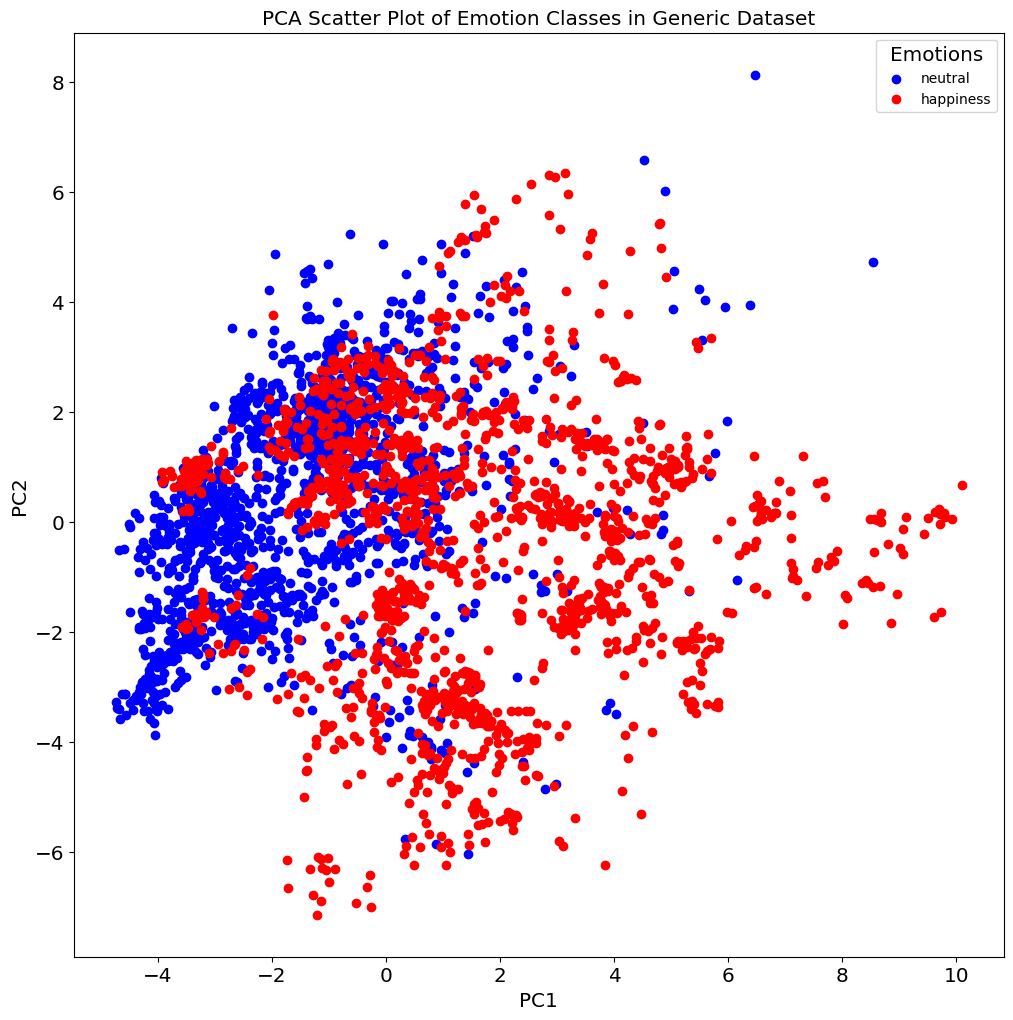

In [23]:
plt.figure(figsize=(12, 12))

# Perform PCA on the feature data
em_pca = PCA(n_components=2)
pca_x = em_pca.fit_transform(final_df[features_Z].values)

# Get unique class labels
em_cat = list(final_df['class'].unique())

# Define custom colormap for the classes
colors = ['blue', 'red', 'green']

# Plot the scatter plot with custom colors
for i, label in enumerate(em_cat):
    class_indices = final_df['class'] == label
    plt.scatter(pca_x[class_indices, 0], pca_x[class_indices, 1], c=colors[i], label=label)

legend = plt.legend(title="Emotions")
legend.get_title().set_fontsize('x-large')  # Increase legend title font size
plt.xlabel('PC1', fontsize='x-large')
plt.ylabel('PC2', fontsize='x-large')
plt.tick_params(labelsize='x-large')  # Increase tick labels font size
plt.title('PCA Scatter Plot of Emotion Classes in Generic Dataset', fontsize='x-large')  # Adding the title
plt.show()

In [24]:
em_pca = PCA(n_components=40)
em_pca.fit(final_df[features_Z].values)
evro = em_pca.explained_variance_ratio_

<font color='blue' size='4'>40 components are needed to cover 99% of the variance!</font>

# Model Selection

## KNN

In [25]:
y = final_df['class'].values
X = final_df[features_Z].values

In [26]:
k_selection=range(1,30) #6
cons = RepeatedKFold(n_splits=5, n_repeats=3, random_state=50)
# knn
em_knn = KNeighborsClassifier()
pms={'n_neighbors': k_selection}
em_gs = GridSearchCV(em_knn, pms, cv=cons, return_train_score=False)
em_gs.fit(X,y)
em_gs.best_params_['n_neighbors']
print("Accuracy:", np.max(em_gs.cv_results_['mean_test_score']))

Accuracy: 0.9191666666666668


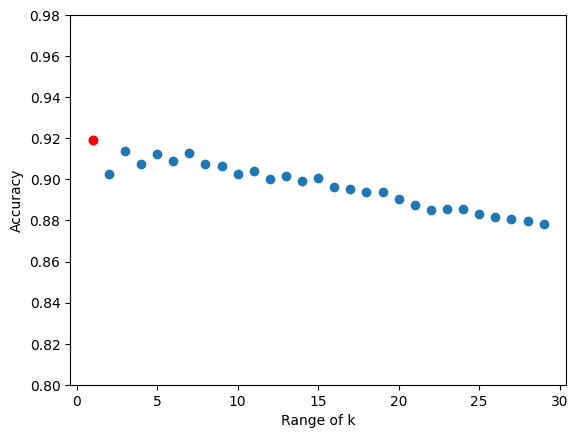

In [27]:
plt.plot(k_selection, em_gs.cv_results_['mean_test_score'],'o')
# highlight the best parameter
plt.plot(em_gs.best_params_['n_neighbors'], np.max(em_gs.cv_results_['mean_test_score']),'ro')
plt.plot()
plt.ylim((0.8,0.98))
plt.xlabel('Range of k')
plt.ylabel('Accuracy');

## Random Forest

In [28]:
y = final_df['class'].values
X = final_df[features_Z].values

In [29]:
rf_clfr = RandomForestClassifier(random_state=20)
cons = RepeatedKFold(n_splits=5, n_repeats=3, random_state=5)

max_depths = [5, 10, 15, 20, None]
max_features = ['sqrt', 'log2', 0.25, 0.5, 0.75, None]
parameters={'max_depth': max_depths,
           'max_features': max_features}

em_gs = GridSearchCV(rf_clfr, parameters, cv=cons, return_train_score=False, n_jobs=-1)
em_gs.fit(X,y)

print('Best hyperparameter combination:')
print('Max Depth:', em_gs.best_params_['max_depth'])
print('Max Feature:', em_gs.best_params_['max_features'])
print("Best accuracy:", np.max(em_gs.cv_results_['mean_test_score']))

Best hyperparameter combination:
Max Depth: None
Max Feature: log2
Best accuracy: 0.940625


In [30]:
comb_params = list(itertools.product(max_depths, max_features))

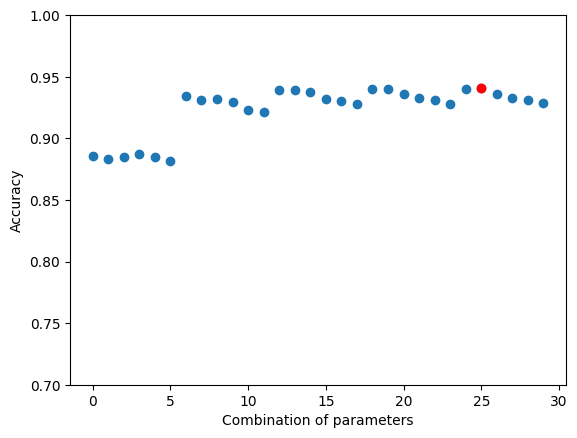

In [31]:
plt.plot(em_gs.cv_results_['mean_test_score'],'o')

ind = np.where((np.array(comb_params)[:,0] == em_gs.best_params_['max_depth']) &
(np.array(comb_params)[:,1] == em_gs.best_params_['max_features']))[0][0]

plt.plot(ind, np.max(em_gs.cv_results_['mean_test_score']),'ro')
plt.plot()
plt.ylim((0.7,1))
plt.xlabel('Combination of parameters')
plt.ylabel('Accuracy');

## MLP

In [32]:
y = final_df['class'].values
X = final_df[features_Z].values

In [33]:
mlp_clfr = MLPClassifier(max_iter=10000, early_stopping=True, random_state=20)

hid_layers_s = [(i,) for i in range(3,8)]
val_frac = [0.1, 0.5]
opt_select = ['adam', 'sgd']
activ_f = ['relu', 'logistic']

parameter_space = {
    'hidden_layer_sizes': hid_layers_s,
    'activation': activ_f,
    'solver': opt_select,
    'validation_fraction': val_frac
}

cons = RepeatedKFold(n_splits=5, n_repeats=3, random_state=5)

# search and select the best hyperparameter combs
em_gs = GridSearchCV(mlp_clfr, parameter_space, cv=cons)
em_gs.fit(X, y)
print('Combination of best hyperparameters:')
print("Best accuracy:", em_gs.best_score_)
em_gs.best_params_

Combination of best hyperparameters:
Best accuracy: 0.8706250000000002


{'activation': 'relu',
 'hidden_layer_sizes': (7,),
 'solver': 'adam',
 'validation_fraction': 0.5}

In [34]:
comb_params = list(itertools.product(activ_f, hid_layers_s, opt_select, val_frac))

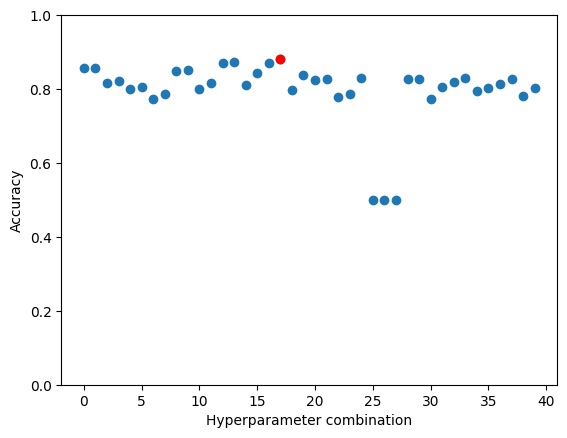

In [35]:
plt.plot(em_gs.cv_results_['mean_test_score'],'o')
# best feature combination
ind = comb_params.index(tuple(em_gs.best_params_.values()))
plt.plot(ind, np.max(em_gs.cv_results_['mean_test_score']),'ro')
plt.plot()
plt.ylim((0,1))
plt.xlabel('Hyperparameter combination')
plt.ylabel('Accuracy');

# Performance Estimation

## KNN

In [30]:
y = final_df['class'].values
X = final_df[features_Z].values

In [31]:
start_time = time.time()

k_selection=range(1,30) 

kfold_outer = KFold(n_splits=10, random_state=10, shuffle=True)
kfold_inner = RepeatedKFold(n_splits=5, n_repeats=3, random_state=50)

# knn classifier
knn_clfr = KNeighborsClassifier()

parameters={'n_neighbors': k_selection}

y_preds_knn = []
y_trues_knn = []
best_hc_knn = []

for train_index, test_index in kfold_outer.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # search and select
    em_gs = GridSearchCV(knn_clfr, parameters, cv=kfold_inner, return_train_score=False)
    em_gs.fit(X_train, y_train)
    # ROAUC
    y_score=em_gs.fit(X_train, y_train).predict_proba(X_test)
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    
    # predict on the the test data useing the selected model
    y_preds_knn.extend(list(em_gs.predict(X_test)))
    y_trues_knn.extend(y_test)
    
    # save the best combination of hyperparameters
    best_hc_knn.append(em_gs.best_params_['n_neighbors'])
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 1025.3776786327362 seconds ---


In [32]:
y_score

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [33]:
label_binarizer.transform(["happiness"])

array([[1, 0, 0]])

In [34]:
class_of_interest = "happiness"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

0

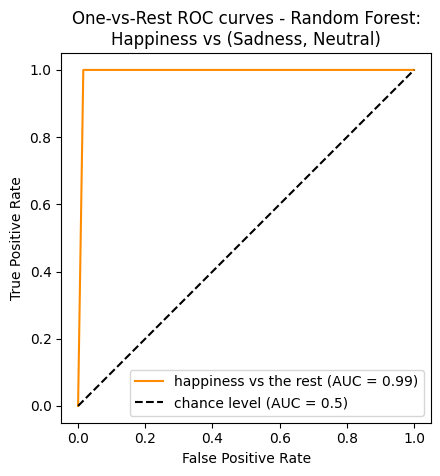

In [35]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves - Random Forest:\nHappiness vs (Sadness, Neutral)")
plt.legend()
plt.show()

In [36]:
print(f"y_score:\n{y_score[0:2,:]}")
print()
print(f"y_score.ravel():\n{y_score[0:2,:].ravel()}")

y_score:
[[0. 0. 1.]
 [0. 0. 1.]]

y_score.ravel():
[0. 0. 1. 0. 0. 1.]


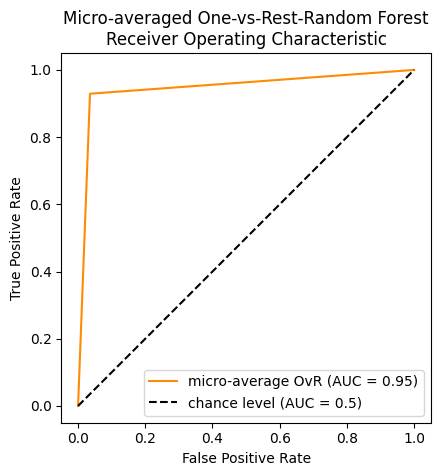

In [37]:
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest-Random Forest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [44]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.95


In [45]:
n_classes = len(np.unique(y))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.95


In [46]:
from sklearn.metrics import roc_auc_score
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.95


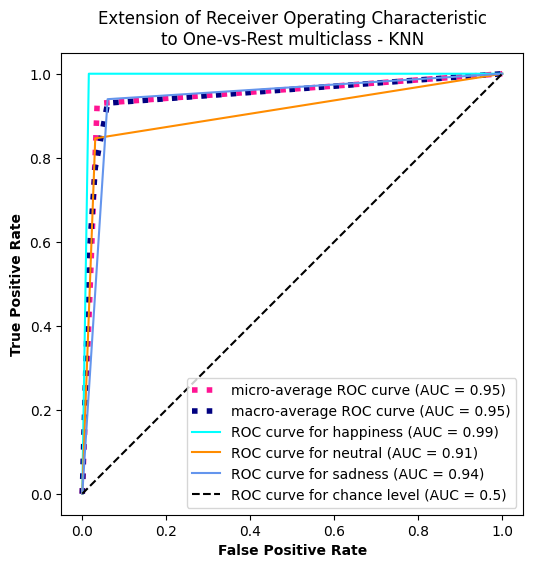

In [51]:
from itertools import cycle
target_names = ["happiness", "neutral", "sadness"]

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass - KNN")
plt.legend()
plt.show()

Predicted: Happiness Neutral Sadness
True: Happiness 1529 58 13
True: Neutral 80 1320 200
True: Sadness 11 88 1501


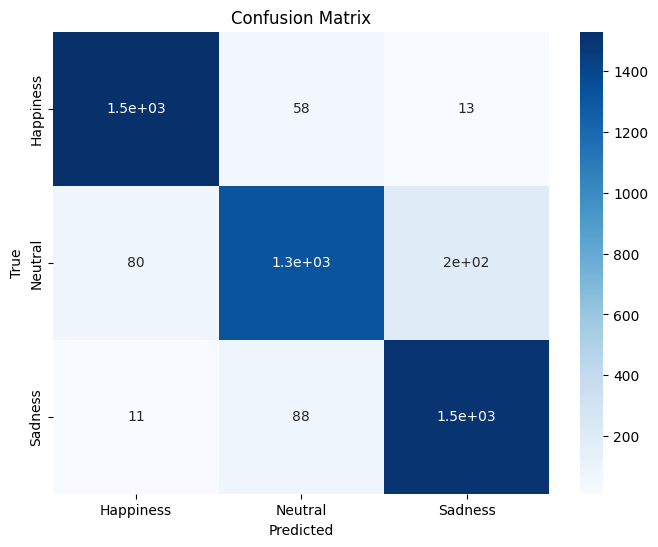

Accuracy: 0.906
best k counts:
1 : 10


In [48]:
# Calculate the confusion matrix
cm = metrics.confusion_matrix(y_trues_knn, y_preds_knn)

# Define the class labels
class_labels = ['Happiness', 'Neutral', 'Sadness']

# Print the predicted and true labels
print('Predicted:', *class_labels)
for i, row in enumerate(cm):
    print('True:', class_labels[i], *row)

# Calculate the accuracy
accuracy = np.round(metrics.accuracy_score(y_trues_knn, y_preds_knn), 3)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the accuracy
print('Accuracy:', accuracy)

print('best k counts:')
for best_k in np.unique(best_hc_knn):
    print(best_k, ':', best_hc_knn.count(best_k))

Confusion Matrix:
Predicted: Happiness Neutral Sadness
True: Happiness  1529    58    13
True: Neutral    80  1320   200
True: Sadness    11    88  1501


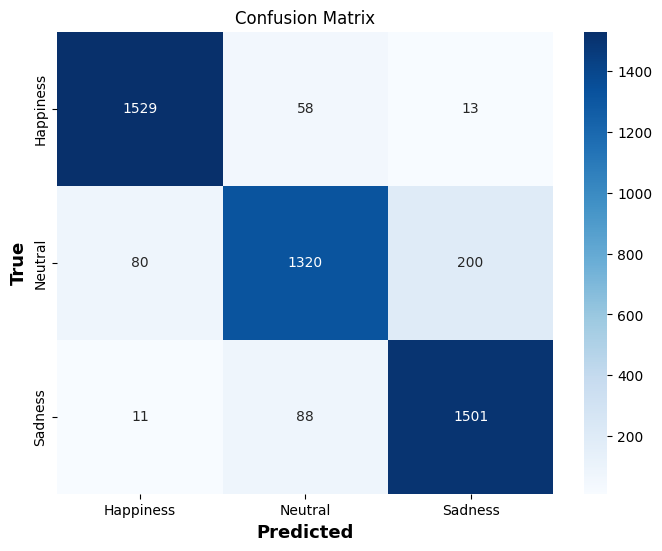

Accuracy: 0.906
best k counts:
1 : 10


In [50]:
# Calculate the confusion matrix
cm = metrics.confusion_matrix(y_trues_knn, y_preds_knn)

# Define the class labels
class_labels = ['Happiness', 'Neutral', 'Sadness']

# Print the confusion matrix with normal formatting
print('Confusion Matrix:')
print('Predicted:', *class_labels)
for i, row in enumerate(cm):
    print('True:', class_labels[i], *[f"{num:5d}" for num in row])

# Calculate the accuracy
accuracy = np.round(metrics.accuracy_score(y_trues_knn, y_preds_knn), 3)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted', fontweight='bold', fontsize=13)
plt.ylabel('True', fontweight='bold', fontsize=13)
plt.show()

# Print the accuracy
print('Accuracy:', accuracy)

print('best k counts:')
for best_k in np.unique(best_hc_knn):
    print(best_k, ':', best_hc_knn.count(best_k))

## Random Forest

In [52]:
start_time = time.time()

kfold_outer = KFold(n_splits=10, random_state=10, shuffle=True)
kfold_inner = RepeatedKFold(n_splits=5, n_repeats=3, random_state=50)

max_depths = [20, None]
max_features = ['sqrt', 'log2']
parameters={'max_depth': max_depths,
           'max_features': max_features}

rf_clfr = RandomForestClassifier(random_state=20)

y_preds = []
y_trues = []
best_p = []

for train_index, test_index in kfold_outer.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # select the best model
    em_gs = GridSearchCV(rf_clfr, parameters, cv=kfold_inner, return_train_score=False)
    em_gs.fit(X_train, y_train)
    # ROAUC
    y_score_rf=em_gs.fit(X_train, y_train).predict_proba(X_test)
    label_binarizer_rf = LabelBinarizer().fit(y_train)
    y_onehot_test_rf = label_binarizer.transform(y_test)
    
    # use the selected model to predict the classes for the test data
    y_preds.extend(list(em_gs.predict(X_test)))
    y_trues.extend(y_test)
    
    # save the best hyperparameter combination
    best_p.append(em_gs.best_params_)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 805.6860909461975 seconds ---


In [53]:
y_score_rf

array([[0.38, 0.06, 0.56],
       [0.  , 0.04, 0.96],
       [0.05, 0.15, 0.8 ],
       ...,
       [0.98, 0.02, 0.  ],
       [0.99, 0.01, 0.  ],
       [0.99, 0.01, 0.  ]])

In [54]:
label_binarizer_rf.transform(["happiness"])

array([[1, 0, 0]])

In [55]:
class_of_interest = "happiness"
class_id = np.flatnonzero(label_binarizer_rf.classes_ == class_of_interest)[0]
class_id

0

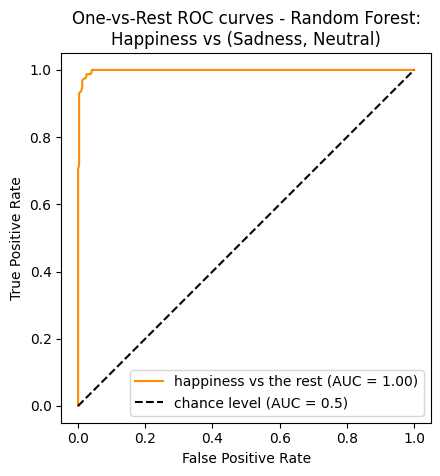

In [56]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test_rf[:, class_id],
    y_score_rf[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves - Random Forest:\nHappiness vs (Sadness, Neutral)")
plt.legend()
plt.show()

In [57]:
print(f"y_score:\n{y_score_rf[0:2,:]}")
print()
print(f"y_score.ravel():\n{y_score_rf[0:2,:].ravel()}")

y_score:
[[0.38 0.06 0.56]
 [0.   0.04 0.96]]

y_score.ravel():
[0.38 0.06 0.56 0.   0.04 0.96]


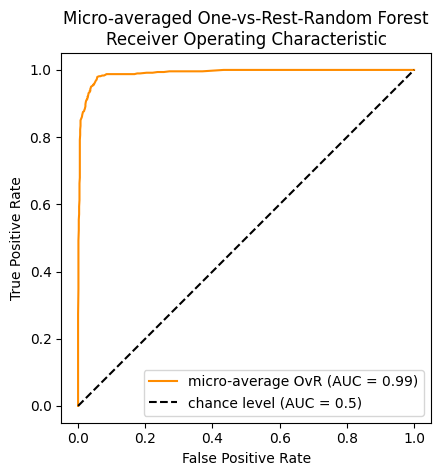

In [58]:
RocCurveDisplay.from_predictions(
    y_onehot_test_rf.ravel(),
    y_score_rf.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest-Random Forest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [59]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test_rf.ravel(), y_score_rf.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.99


In [60]:
n_classes = len(np.unique(y))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test_rf[:, i], y_score_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.99


In [61]:
from sklearn.metrics import roc_auc_score
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score_rf,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.99


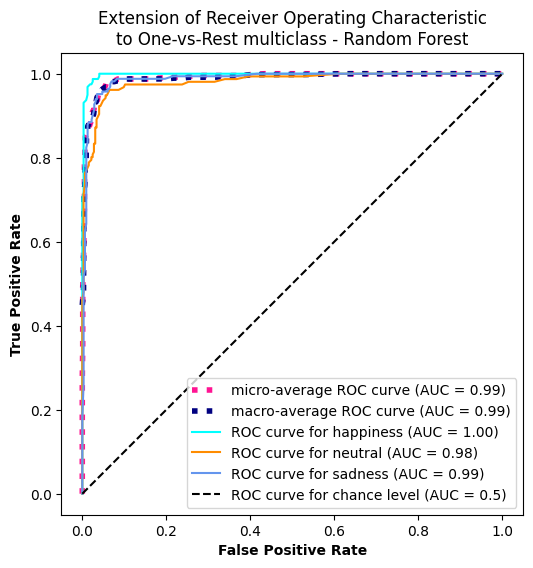

In [66]:
from itertools import cycle
target_names = ["happiness", "neutral", "sadness"]

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test_rf[:, class_id],
        y_score_rf[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass - Random Forest")
plt.legend()
plt.show()

Predicted: Happiness Neutral Sadness
True: Happiness 1557 38 5
True: Neutral 67 1411 122
True: Sadness 9 68 1523


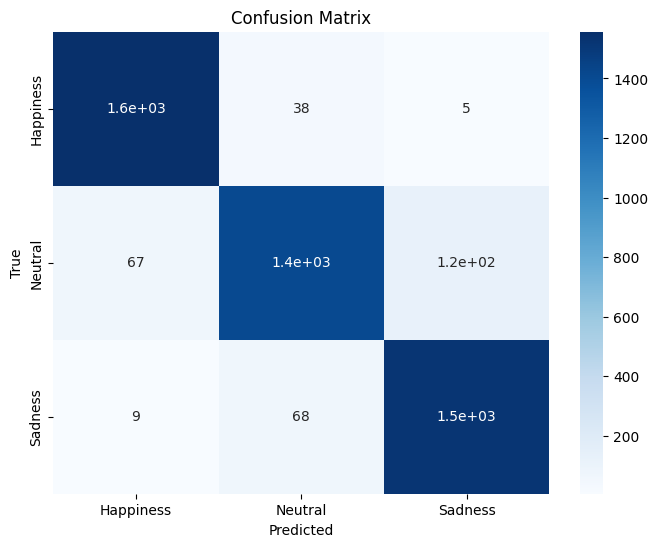

Accuracy: 0.936
Combinations of Best Parameters:
(max_depth, max_features): number of counts


Counter({(None, 'sqrt'): 5,
         (20, 'log2'): 1,
         (None, 'log2'): 2,
         (20, 'sqrt'): 2})

In [63]:
# Calculate the confusion matrix
cm = metrics.confusion_matrix(y_trues, y_preds)

# Define the class labels
class_labels = ['Happiness', 'Neutral', 'Sadness']

# Print the predicted and true labels
print('Predicted:', *class_labels)
for i, row in enumerate(cm):
    print('True:', class_labels[i], *row)

# Calculate the accuracy
accuracy = np.round(metrics.accuracy_score(y_trues, y_preds), 3)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the accuracy
print('Accuracy:', accuracy)

# Print the combinations of best parameters
print('Combinations of Best Parameters:')
print('(max_depth, max_features): number of counts')
par1 = [i['max_depth'] for i in best_p]
par2 = [i['max_features'] for i in best_p]
pars = list(zip(par1, par2))
Counter(pars)

Confusion Matrix:
Predicted: Happiness Neutral Sadness
True: Happiness  1557    38     5
True: Neutral    67  1411   122
True: Sadness     9    68  1523


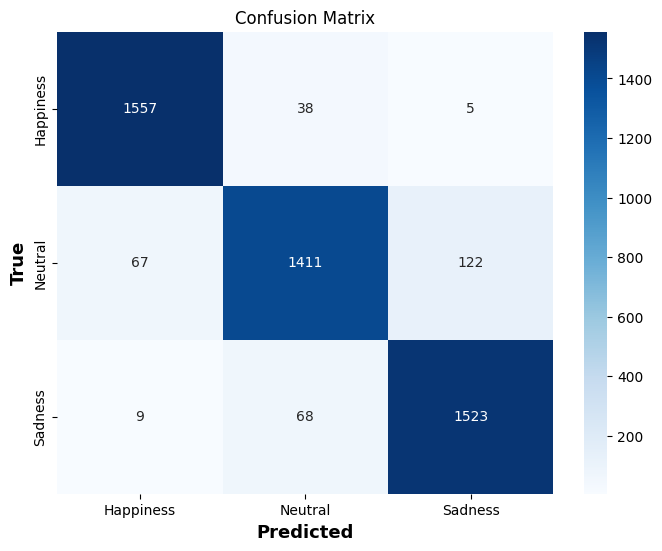

Accuracy: 0.936
Combinations of Best Parameters:
(max_depth, max_features): number of counts
(None, 'sqrt'): 5
(20, 'log2'): 1
(None, 'log2'): 2
(20, 'sqrt'): 2


In [65]:
from collections import Counter

# Calculate the confusion matrix
cm = metrics.confusion_matrix(y_trues, y_preds)

# Define the class labels
class_labels = ['Happiness', 'Neutral', 'Sadness']

# Print the confusion matrix with normal formatting
print('Confusion Matrix:')
print('Predicted:', *class_labels)
for i, row in enumerate(cm):
    print('True:', class_labels[i], *[f"{num:5d}" for num in row])

# Calculate the accuracy
accuracy = np.round(metrics.accuracy_score(y_trues, y_preds), 3)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted', fontweight='bold', fontsize=13)
plt.ylabel('True', fontweight='bold', fontsize=13)
plt.show()

# Print the accuracy
print('Accuracy:', accuracy)

# Print the combinations of best parameters with normal formatting
print('Combinations of Best Parameters:')
print('(max_depth, max_features): number of counts')
par1 = [i['max_depth'] for i in best_p]
par2 = [i['max_features'] for i in best_p]
pars = list(zip(par1, par2))
for par, count in Counter(pars).items():
    print(f"{par}: {count}")


## MLP

In [67]:
start_time = time.time()

hid_layers_s = [(i,) for i in range(3,6)]
val_frac = [0.1, 0.5]
opt_select = ['adam', 'sgd']
activ_f = ['relu', 'logistic']

parameters = {
    'hidden_layer_sizes': hid_layers_s,
    'activation': activ_f,
    'solver': opt_select,
    'validation_fraction': val_frac
}

kfold_outer = KFold(n_splits=10, random_state=10, shuffle=True)
kfold_inner = RepeatedKFold(n_splits=5, n_repeats=3, random_state=50)

mlp_clfr = MLPClassifier(max_iter=10000, early_stopping=True, random_state=20)

y_preds_mlp = []
y_trues_mlp = []
best_p_mlp = []

for train_index, test_index in kfold_outer.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # select the best model
    em_gs = GridSearchCV(mlp_clfr, parameters, cv=kfold_inner, return_train_score=False)
    em_gs.fit(X_train, y_train)
    
    # ROAUC
    y_score_mlp=em_gs.fit(X_train, y_train).predict_proba(X_test)
    label_binarizer_mlp = LabelBinarizer().fit(y_train)
    y_onehot_test_mlp = label_binarizer.transform(y_test)
    
    # use the selected model to predict the classes for the test data
    y_preds_mlp.extend(list(em_gs.predict(X_test)))
    y_trues_mlp.extend(y_test)
    
    # save the best hyperparameter combination
    best_p_mlp.append(em_gs.best_params_)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 8911.871208667755 seconds ---


In [68]:
y_score_mlp

array([[6.42597487e-02, 3.10182616e-02, 9.04721990e-01],
       [8.55436777e-02, 6.46776681e-02, 8.49778654e-01],
       [2.72330472e-01, 2.19073992e-01, 5.08595536e-01],
       ...,
       [9.48181308e-01, 5.15253868e-02, 2.93305233e-04],
       [9.59036000e-01, 4.06666934e-02, 2.97306535e-04],
       [8.54398968e-01, 1.04656518e-01, 4.09445144e-02]])

In [69]:
label_binarizer_mlp.transform(["happiness"])

array([[1, 0, 0]])

In [70]:
class_of_interest = "happiness"
class_id = np.flatnonzero(label_binarizer_mlp.classes_ == class_of_interest)[0]
class_id

0

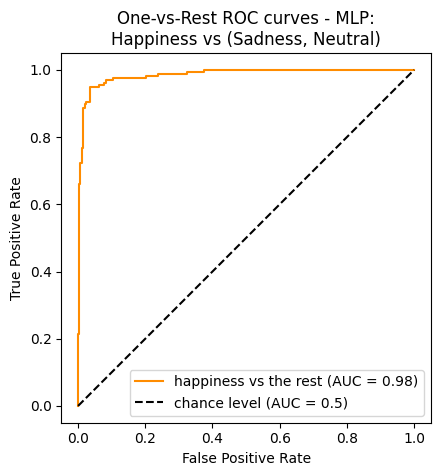

In [71]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test_mlp[:, class_id],
    y_score_mlp[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves - MLP:\nHappiness vs (Sadness, Neutral)")
plt.legend()
plt.show()

In [72]:
print(f"y_score:\n{y_score_mlp[0:2,:]}")
print()
print(f"y_score.ravel():\n{y_score_mlp[0:2,:].ravel()}")

y_score:
[[0.06425975 0.03101826 0.90472199]
 [0.08554368 0.06467767 0.84977865]]

y_score.ravel():
[0.06425975 0.03101826 0.90472199 0.08554368 0.06467767 0.84977865]


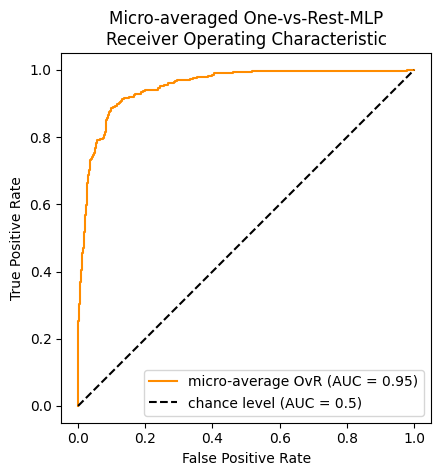

In [73]:
RocCurveDisplay.from_predictions(
    y_onehot_test_mlp.ravel(),
    y_score_mlp.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest-MLP\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [85]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test_mlp.ravel(), y_score_mlp.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.91


In [86]:
n_classes = len(np.unique(y))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test_mlp[:, i], y_score_mlp[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.91


In [87]:
from sklearn.metrics import roc_auc_score
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score_mlp,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.91


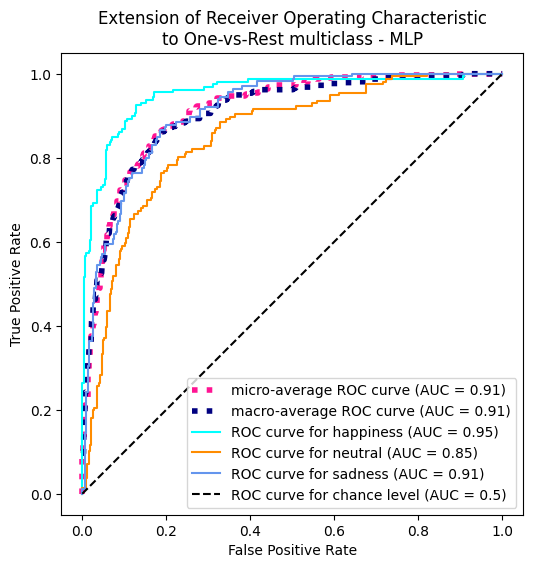

In [88]:
from itertools import cycle
target_names = ["happiness", "neutral", "sadness"]

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test_mlp[:, class_id],
        y_score_mlp[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass - MLP")
plt.legend()
plt.show()

Predicted: Happiness Neutral Sadness
True: Happiness 1455 86 59
True: Neutral 116 1185 299
True: Sadness 67 211 1322


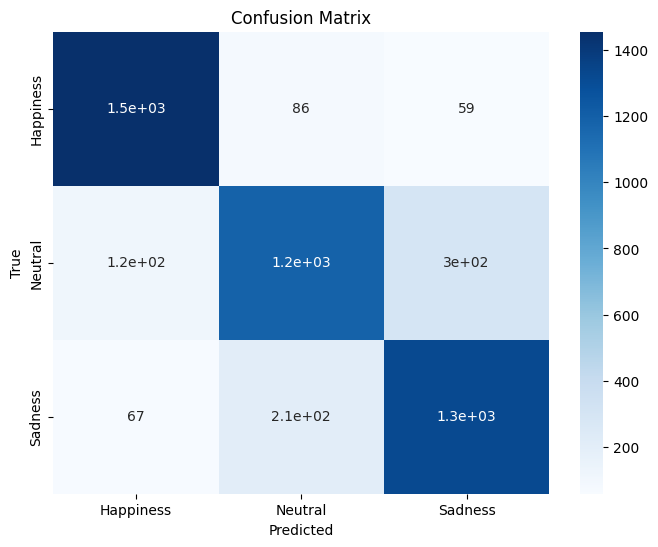

Accuracy: 0.825
Combinations of Best Parameters:
(activation functions, hidden_layer_sizes, solver - optimizer, validation_frac): number of counts


Counter({('relu', (5,), 'adam', 0.1): 3, ('relu', (5,), 'adam', 0.5): 7})

In [74]:
# Calculate the confusion matrix
cm = metrics.confusion_matrix(y_trues_mlp, y_preds_mlp)

# Define the class labels
class_labels = ['Happiness', 'Neutral', 'Sadness']

# Print the predicted and true labels
print('Predicted:', *class_labels)
for i, row in enumerate(cm):
    print('True:', class_labels[i], *row)

# Calculate the accuracy
accuracy = np.round(metrics.accuracy_score(y_trues_mlp, y_preds_mlp), 3)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the accuracy
print('Accuracy:', accuracy)

print('Combinations of Best Parameters:')
print('(activation functions, hidden_layer_sizes, solver - optimizer, validation_frac): number of counts')
Counter([tuple(best_p_mlp[i].values()) for i in range(len(best_p_mlp))])

Confusion Matrix:
Predicted: Happiness Neutral Sadness
True: Happiness  1455    86    59
True: Neutral   116  1185   299
True: Sadness    67   211  1322


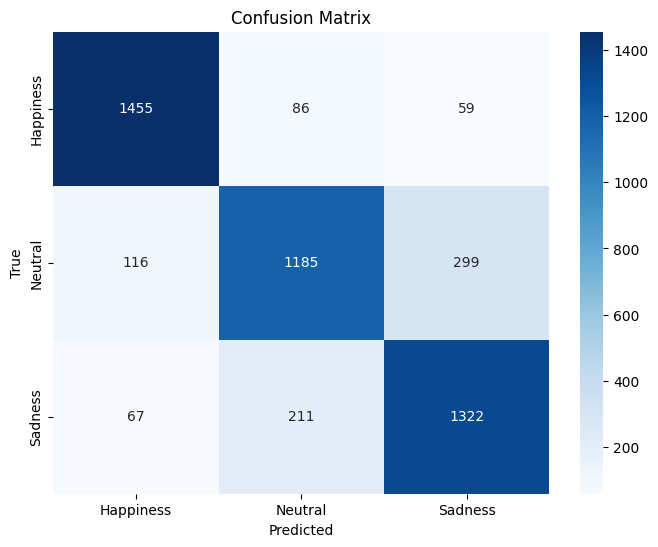

Accuracy: 0.825
Combinations of Best Parameters:
(activation functions, hidden_layer_sizes, solver - optimizer, validation_frac): number of counts
('relu', (5,), 'adam', 0.1): 3
('relu', (5,), 'adam', 0.5): 7


In [75]:
from collections import Counter

# Calculate the confusion matrix
cm = metrics.confusion_matrix(y_trues_mlp, y_preds_mlp)

# Define the class labels
class_labels = ['Happiness', 'Neutral', 'Sadness']

# Print the confusion matrix with normal formatting
print('Confusion Matrix:')
print('Predicted:', *class_labels)
for i, row in enumerate(cm):
    print('True:', class_labels[i], *[f"{num:5d}" for num in row])

# Calculate the accuracy
accuracy = np.round(metrics.accuracy_score(y_trues_mlp, y_preds_mlp), 3)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the accuracy
print('Accuracy:', accuracy)

# Print the combinations of best parameters with normal formatting
print('Combinations of Best Parameters:')
print('(activation functions, hidden_layer_sizes, solver - optimizer, validation_frac): number of counts')
best_p_mlp_combinations = [tuple(best_p_mlp[i].values()) for i in range(len(best_p_mlp))]
for par, count in Counter(best_p_mlp_combinations).items():
    print(f"{par}: {count}")